# Explicit

## Forward Euler

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from typing import Tuple
from tqdm import tqdm

def _solve_pde(self, D1_prime: float, DT_0: float, T: float, X: float, L: float, dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Solve PDE with stability monitoring
    
    ∂D'/∂t = (DT_0/L²) * D' * (∂²D'/∂x²)
    
    Finite Difference Scheme
    - Forward difference in time
    - Central difference in space
    
    Discretization
    ∂D'/∂t ≈ (D'[n+1,i] - D'[n,i])/dt
    ∂²D'/∂x² ≈ (D'[n,i+1] - 2D'[n,i] + D'[n,i-1])/dx²

    Stability Criterion
    dt ≤ dx²/(2*DT_0*D1')
            
    Matrix form:
    D'[n+1] = D'[n] + r * D'[n] * (AD'[n])
    Where:
    - r = dt*DT_0/L²
    - A: Tridiagonal matrix for ∂²/∂x²
    
    Known undersirable behaviours:
    - dx <= 0.01 -> unstable.
    - d2D = laplacian.dot(D_prime[n-1, 1:-1]) -> causes internal points to drop to 0 at t > 0

    
    """
    # Grid setup
    Nx = int(X/dx) + 1
    Nt = int(T/dt) + 1
    
    # Initialize arrays
    x = np.linspace(0, X, Nx)
    t = np.linspace(0, T, Nt)
    D_prime = np.zeros((Nt, Nx))
    
    # Initialise
    D_prime[0, :] = 1.0  # Example initial condition, modify as necessary
    
    # Boundary conditions
    D_prime[:, 0] = D1_prime     # x=0
    D_prime[:, -1] = D2_prime    # x=L
    
    # Pre-compute constants
    r = dt * DT_0 / (L**2)
    
    # Esitmate second derivative operator (sparse matrix) ưith laplacian
    Nx_interior = Nx - 2  # Number of interior points
    diagonals = [np.ones(Nx_interior-1), -2*np.ones(Nx_interior), np.ones(Nx_interior-1)]
    laplacian = sp.diags(diagonals, offsets=[-1, 0, 1], shape=(Nx_interior, Nx_interior), format='csr') / dx**2

    # Time stepping with progress bar
    # Progress bar
    pbar = tqdm(
        total=Nt-1,
        desc=f"Solving PDE (D1'={D1_prime:.2f}, DT_0={DT_0:.2e})",
        unit='steps',
        ncols=100
    )
    
    # Time stepping
    for n in range(1, Nt):
        # Internal-point stepping
        for i in range(1, Nx-1):
            d2D = (D_prime[n-1, i+1] - 2 * D_prime[n-1, i] + D_prime[n-1, i-1]) / dx**2     # stable
            D_prime[n, i] = D_prime[n-1, i] + r * D_prime[n-1, i] * d2D
        
        pbar.update(1)
    
    pbar.close()
    
    # Calculate flux
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create output DataFrames
    Dprime_df = pd.DataFrame(D_prime, columns=[f'x={x_i:.3f}' for x_i in x])
    Dprime_df.index = t
    
    flux_df = pd.DataFrame({
        'time': t,
        'normalised_flux': F_norm,
        'tau': DT_0 * t / L**2
    })
    
    return Dprime_df, flux_df



# Implicit 

## Crank-Nicolson

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from typing import Tuple
from tqdm import tqdm

def _solve_pde(self, D1_prime: float, DT_0: float, T: float, X: float, L: float, dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Solve PDE with Crank-Nicholson (implicit).

    """
    # Check D1_prime and D2_prime
    if D1_prime <= 0 or D2_prime <= 0:
        raise ValueError(f'D1_prime ({D1_prime}) and D2_prime ({D2_prime}) must be positive')
    if D1_prime <= D2_prime:
        raise ValueError(f'D1_prime ({D1_prime}) must be greater than D2_prime ({D2_prime})')
    
    # Grid setup
    Nx = int(X/dx) + 1
    Nt = int(T/dt) + 1
    
    # Initialize arrays
    x = np.linspace(0, X, Nx)
    t = np.linspace(0, T, Nt)
    
    # Initial condition
    D_prime = np.ones((Nt, Nx))  # Initial condition
    
    # Boundary conditions
    D_prime[:, 0] = D1_prime     # x=0
    D_prime[:, -1] = D2_prime    # x=L
    
    # Pre-compute constants
    r = (DT_0 / L**2) * (dt / dx**2)
    
    # Construct tridiagonal matrix A for interior points (size Nx-2)
    diagonals = [
        -r * np.ones(Nx - 3),  # Lower diagonal
        (1 + 2 * r) * np.ones(Nx - 2),  # Main diagonal
        -r * np.ones(Nx - 3)   # Upper diagonal
    ]
    A = sp.diags(diagonals, offsets=[-1, 0, 1], format="csr")

    # Store flux values
    F_norm = np.zeros(Nt)
    
    # Time stepping with progress bar
    # Progress bar
    pbar = tqdm(
        total=Nt-1,
        desc=f"Solving PDE (D1'={D1_prime:.2f}, DT_0={DT_0:.2e})",
        unit='steps',
        ncols=100
    )
    try:
        for n in range(1, Nt):
            # Update interior points using implicit Euler method
            b = D_prime[n-1, 1:-1].copy()
            
            # Apply boundary conditions explicitly to RHS
            b[0] += r * D_prime[n, 0]    # Left boundary
            b[-1] += r * D_prime[n, -1]  # Right boundary
            
            D_new = spsolve(A, b)
            
            # Check for instabilities
            if not np.all(np.isfinite(D_new)):
                raise ValueError(f"Solution became unstable at t={t[n]:.2e}")
            
            D_prime[n, 1:-1] = D_new
            pbar.update(1)
            
            if n % 100 == 0:
                pbar.set_postfix({
                    'tau': f"{DT_0 * t[n] / L**2:.2e}",
                    'max_D': f"{np.max(D_new):.2e}"
                })
    
    except Exception as e:
        pbar.close()
        raise e
    pbar.close()
    
    # Create output DataFrames
    Dprime_df = pd.DataFrame(D_prime, columns=[f"x={x_i:.3f}" for x_i in x])
    Dprime_df.index = t
    
    flux_df = pd.DataFrame({
        'time': t,
        'normalised_flux': F_norm,
        'tau': DT_0 * t / L**2
    })
    
    return Dprime_df, flux_df

## Implicit Euler

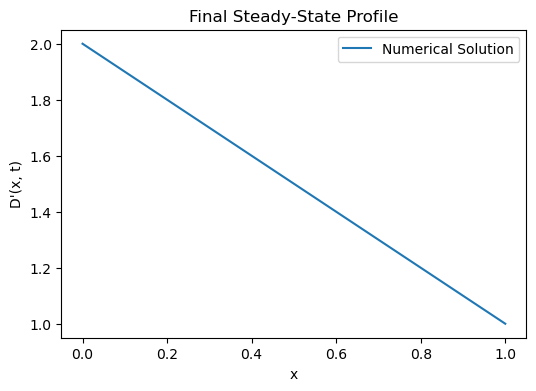

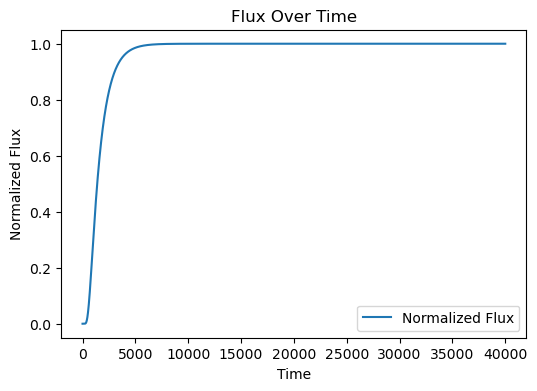

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import pandas as pd

# Main parameters
DT_0 = 1e-6
D1_prime = 2.0

# Grid parameters
Nx = 51  # Spatial points
Nt = 40001  # Time points
X = 1.0  # Domain length
T = 40e3  # Total time

dx = X / (Nx - 1)
dt = T / (Nt - 1)
L = 0.1

r = (DT_0 / L**2) * (dt / dx**2)

# Spatial grid and initial conditions
x = np.linspace(0, X, Nx)
t = np.linspace(0, T, Nt)
D_prime = np.ones(Nx)  # Initial condition
D_prime[0] = D1_prime  # Left boundary condition (D1')
D_prime[-1] = 1.0  # Right boundary condition (D2')

# Construct tridiagonal matrix A for interior points (size Nx-2)
diagonals = [
    -r * np.ones(Nx - 3),  # Lower diagonal
    (1 + 2 * r) * np.ones(Nx - 2),  # Main diagonal
    -r * np.ones(Nx - 3)   # Upper diagonal
]
A = sp.diags(diagonals, offsets=[-1, 0, 1], format="csr")

# Store flux values
F_norm = np.zeros(Nt)

# Time stepping
for n in range(1, Nt):
    # Right-hand side (RHS)
    rhs = D_prime[1:-1].copy()  # Only interior points
    
    # Apply boundary conditions explicitly to RHS
    rhs[0] += r * D_prime[0]    # Left boundary
    rhs[-1] += r * D_prime[-1]  # Right boundary

    # Solve linear system for interior points
    D_prime[1:-1] = spla.spsolve(A, rhs)

    # Calculate flux at right boundary
    F_norm[n] = (-(D_prime[-1] - D_prime[-2]) / dx) / (-(D_prime[-1] - D_prime[0]) / X)

# Create DataFrames for results
Dprime_df = pd.DataFrame(D_prime.reshape(1, -1), columns=[f"x={x_i:.3f}" for x_i in x])
Dprime_df.index = ["Final Time Step"]

flux_df = pd.DataFrame({
    "time": t,
    "normalized_flux": F_norm,
    "tau": DT_0 * t / L**2
})

# Plot final steady-state solution
plt.figure(figsize=(6, 4))
plt.plot(x, D_prime, label="Numerical Solution")
plt.xlabel("x")
plt.ylabel("D'(x, t)")
plt.title("Final Steady-State Profile")
plt.legend()
plt.show()

# Plot flux over time
plt.figure(figsize=(6, 4))
plt.plot(t, F_norm, label="Normalized Flux")
plt.xlabel("Time")
plt.ylabel("Normalized Flux")
plt.title("Flux Over Time")
plt.legend()
plt.show()


C:\Users\sieun\AppData\Local\Temp\ipykernel_2028\2100902842.py:39: RuntimeWarning: invalid value encountered in divide
  F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)


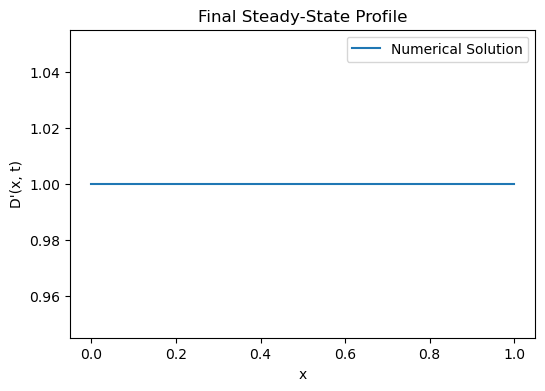

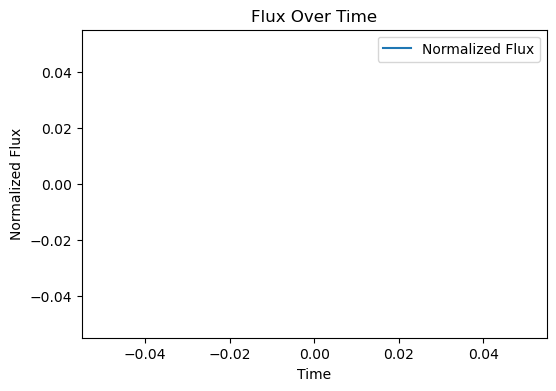

In [9]:
import numpy as np
import pandas as pd

def _solve_pde(D1_prime: float, DT_0: float, T: float, X: float, L: float, dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0):
    """
    Solve PDE with NumPy vectorization:
        ∂D'/∂t = (DT_0 / L^2) * D' * (∂^2D'/∂x^2)
    using an explicit (forward Euler) scheme for illustration.
    """
    # Grid setup
    Nx = int(X / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, X, Nx)
    t = np.linspace(0, T, Nt)
    
    # Initialize D_prime
    D_prime = np.ones((Nt, Nx))  # fill initial with 1
    # Boundary conditions
    D_prime[:, 0] = D1_prime
    D_prime[:, -1] = D2_prime
    
    # Constants
    coeff = (DT_0 / L**2) * (dt / dx**2)
    
    # Time-stepping
    for n in range(1, Nt):
        # Grab previous time step
        D_prev = D_prime[n-1, :]
        
        # Calculate second derivative at all interior points (vectorized)
        d2D = (D_prev[2:] - 2.0 * D_prev[1:-1] + D_prev[:-2])
        
        # Vector update for interior points: i in [1, Nx-2]
        # D'[n+1, i] = D'[n, i] + coeff * D'[n, i] * d2D[i-1]
        D_prime[n, 1:-1] = D_prev[1:-1] + coeff * D_prev[1:-1] * d2D
    
    # Calculate normalized flux at each time step
    # flux = -(D(n, end) - D(n, end-1))/dx, then normalized
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create output DataFrames
    Dprime_df = pd.DataFrame(D_prime, columns=[f"x={v:.3f}" for v in x], index=t)
    flux_df = pd.DataFrame(
        {
            "time": t,
            'tau': DT_0 * t / L**2,
            "normalised_flux": F_norm,
        }
    )
    
    # Plot final steady-state solution
    plt.figure(figsize=(6, 4))
    plt.plot(x, D_prime[-1, :], label="Numerical Solution")
    plt.xlabel("x")
    plt.ylabel("D'(x, t)")
    plt.title("Final Steady-State Profile")
    plt.legend()
    plt.show()

    # Plot flux over time
    plt.figure(figsize=(6, 4))
    plt.plot(t, F_norm, label="Normalized Flux")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.title("Flux Over Time")
    plt.legend()
    plt.show()
    return Dprime_df, flux_df

Dprime_df, flux_df = _solve_pde(D1_prime=1.0, DT_0=1e-7, T=40e3, X=1.0, L=0.1, 
                                dt=0.1, dx=0.01)



## Newton-Raphson Method

### Algorithm Iterations

#### Iteration 1: Core Algorithm

Explanation (High-Level):
- We define K = DT_0 / L² and compute Nx, Nt from dt, dx, domain length.
- At each time step n, we do a Newton iteration on the interior points [1:-1].
- We compute the residual R that encodes the discrete PDE:
  (D_new - D_old)/dt - K⋅D_new⋅laplacian(D_new) = 0.
- We approximate the diagonal terms of its Jacobian (“minus K times laplacian(D_new)”), and do a naive diagonal update.
- This approach is a simplified demonstration (a full Newton iteration typically involves assembling the entire Jacobian as a tridiagonal or banded matrix).
- If R is small (below tol), we consider convergence achieved and proceed to the next time step.

C:\Users\sieun\AppData\Local\Temp\ipykernel_2028\2100902842.py:39: RuntimeWarning: invalid value encountered in divide
  F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)


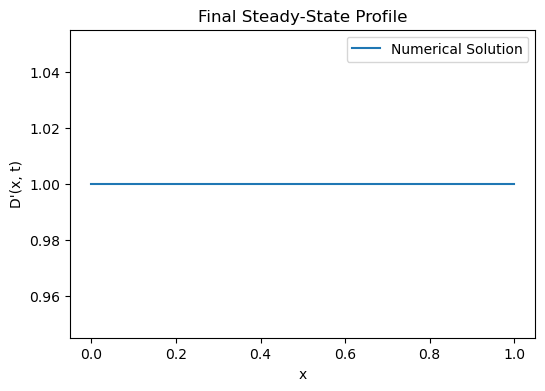

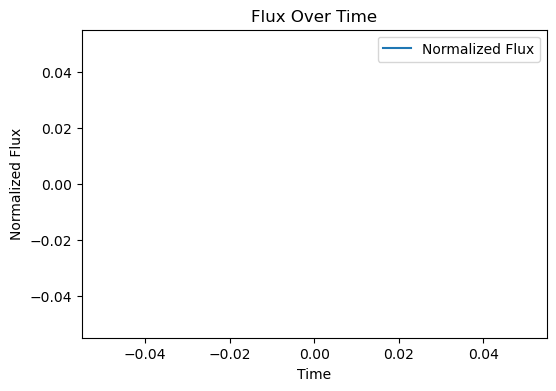

In [10]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def solve_pde_newton(D1_prime: float, D2_prime: float, DT_0: float, L: float, 
                     T: float, X: float, dt: float, dx: float, 
                     tol: float = 1e-6, max_iter: int = 8) -> np.ndarray:
    """
    Solve a nonlinear PDE of the form:
        ∂D'/∂t = (DT_0/L^2) * D' * (∂²D'/∂x²)
    using a Newton iteration at each time step.

    Parameters
    ----------
    D1_prime  : float
        Left boundary condition (x=0). Must be > 0.
    D2_prime  : float
        Right boundary condition (x=X). Must be > 0.
    DT_0      : float
        Reference diffusivity.
    L         : float
        Membrane length scale (for non-dimensionalization).
    T         : float
        Total simulation time.
    X         : float
        Membrane thickness (domain length in x).
    dt        : float
        Time step size.
    dx        : float
        Spatial step size.
    tol       : float
        Convergence tolerance for Newton iteration.
    max_iter  : int
        Maximum number of Newton iterations per time step.

    Returns
    -------
    D_prime : np.ndarray
        2D array of shape (Nt, Nx) containing the solution D'(t, x).
    """

    # Checks
    if D1_prime <= 0 or D2_prime <= 0:
        raise ValueError("Boundary conditions must be positive.")
    if D1_prime <= D2_prime:
        raise ValueError("D1_prime must be greater than D2_prime for this setup.")

    # Constants
    K = DT_0 / (L ** 2)
    Nx = int(X / dx) + 1
    Nt = int(T / dt) + 1

    # Grid
    x = np.linspace(0, X, Nx)
    t = np.linspace(0, T, Nt)

    # Initialize solution array
    D_prime = np.ones((Nt, Nx))
    # Boundary conditions
    D_prime[:, 0] = D1_prime
    D_prime[:, -1] = D2_prime

    # Helper: Compute second derivative using central difference
    def laplacian(vec):
        """Return ∂²vec/∂x² (central difference) for the interior points only."""
        return (vec[2:] - 2.0 * vec[1:-1] + vec[:-2]) / (dx ** 2)

    # Time stepping
    for n in range(1, Nt):
        # D_old is the solution at previous time step
        D_old = D_prime[n - 1].copy()
        # Newton iteration guess (start from D_old)
        D_new = D_old.copy()

        for _ in range(max_iter):
            # 1) Compute the residual at interior points
            # PDE: [D_new(i) - D_old(i)] / dt - K * D_new(i) * laplacian(D_new)(i) = 0
            d2 = laplacian(D_new)
            # interior indices [1:-1]
            R = (D_new[1:-1] - D_old[1:-1]) / dt - K * D_new[1:-1] * d2

            # 2) Check convergence
            norm_R = np.linalg.norm(R, ord=2)
            if norm_R < tol:
                break

            # 3) Approximate Jacobian for interior points
            # J(i,i) ~ ∂R_i/∂D_new(i)
            # R_i = [D_new(i)-D_old(i)]/dt - K*D_new(i)*(D_new(i+1)-2D_new(i)+D_new(i-1))/dx^2
            # We'll do a simplified diagonal approximation:
            # ∂R_i/∂D_new(i) ~ 1/dt - K*(some approximate derivative)...

            # For a more rigorous approach, you'd form the full banded matrix here.
            # Below is a naive diagonal approach for demonstration only:
            main_diag = (1.0 / dt) - K * ( (D_new[2:] - 2*D_new[1:-1] + D_new[:-2]) / (dx**2) )
            # Add partial derivative from the product with D_new:
            # R_i also depends on D_new(i) in the factor "D_new(i)" in front of the laplacian
            # => an additional term: -K * laplacian(D_new)(i). 
            main_diag -= K * laplacian(D_new)

            # 4) Perform a naive diagonal Newton update
            # newton step: D_new[i] -= R[i]/J[i,i]
            D_new[1:-1] -= R / main_diag

            # Re-apply boundary conditions
            D_new[0]  = D1_prime
            D_new[-1] = D2_prime

        # Accept converged solution
        D_prime[n] = D_new

    # Calculate normalized flux at each time step
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Plot final steady-state solution
    plt.figure(figsize=(6, 4))
    plt.plot(x, D_prime[-1, :], label="Numerical Solution")
    plt.xlabel("x")
    plt.ylabel("D'(x, t)")
    plt.title("Final Steady-State Profile")
    plt.legend()
    plt.show()

    # Plot flux over time
    plt.figure(figsize=(6, 4))
    plt.plot(t, F_norm, label="Normalized Flux")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.title("Flux Over Time")
    plt.legend()
    plt.show()
    return Dprime_df, flux_df

Dprime_df, flux_df = _solve_pde(D1_prime=1.0, DT_0=1e-7, T=40e3, X=1.0, L=0.1, 
                                dt=0.1, dx=0.01)

In [55]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from typing import Tuple

def _solve_pde_newton(D1_prime: float, DT_0: float, T: float, X: float, L: float,
                      dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0,
                      rtol: float = 1e-6, max_iter: int = 1000, relax: float = 0.5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Solve the nonlinear PDE:
         ∂D′/∂t = (DT_0/L²)·D′·(∂²D′/∂x²)
    using an implicit time discretization with Newton's method for the nonlinearity.
    
    The Newton update is based on the residual
         R = (D_new - D_old)/dt - K * D_new * laplacian(D_new)
    and a diagonal approximation for the Jacobian.
    """
    # Ensure double precision for critical parameters
    dt = np.float64(dt)
    dx = np.float64(dx)
    
    # Stability hint: For central differences, dt should be O(dx^2)
    # if dt > 0.5 * dx**2:
    #     print("Warning: dt may be too large relative to dx^2, increasing truncation error.")
        
    # Check boundary conditions
    if D1_prime <= 0 or D2_prime <= 0:
        raise ValueError("Boundary conditions must be positive")
    if D1_prime <= D2_prime:
        raise ValueError("D1_prime must be greater than D2_prime")
    
    # Grid setup
    Nx = int(X/dx) + 1
    Nt = int(T/dt) + 1
    x = np.linspace(0, X, Nx)
    t = np.linspace(0, T, Nt)
    
    # K constant (from DT_0/L²)
    K = DT_0 / (L**2)
    
    # Initialize solution array with initial condition
    D_prime = np.ones((Nt, Nx))
    D_prime[:, 0] = D1_prime
    D_prime[:, -1] = D2_prime
    
    # Helper function: compute second derivative using central differences (for interior points)
    def laplacian(vec):
        return (vec[2:] - 2.0 * vec[1:-1] + vec[:-2]) / (dx**2)
    
    # Newton iteration for each time step, with a progress bar
    pbar = tqdm(total=Nt - 1, desc=f"Newton PDE Solve (D1'={D1_prime}, DTO={DT_0})", ncols=100)
    for n in range(1, Nt):
        D_old = D_prime[n-1].copy()   # previous time step solution
        D_new = D_old.copy()          # initial guess for current time step
        
        # Newton iterations to solve the nonlinear update at time tn+1
        for it in range(max_iter):
            # Compute residual for interior nodes:
            # R = (D_new - D_old)/dt - K * D_new * (∂²D_new/∂x²)
            lapl = laplacian(D_new)
            R = (D_new[1:-1] - D_old[1:-1]) / dt - K * D_new[1:-1] * lapl
            
            # Relative tolerance check: norm(R) relative to norm(D_new interior)
            norm_R = np.linalg.norm(R, ord=2)
            norm_D = np.linalg.norm(D_new[1:-1], ord=2)
            if norm_D == 0:
                norm_D = 1e-12
            if norm_R / norm_D < rtol:
                break
            
            # Compute a diagonal (naive) Jacobian approximation.
            #
            # The residual at interior point i is:
            #   R_i = [D_new[i] - D_old[i]]/dt - K*D_new[i]*(D_new[i+1] - 2*D_new[i] + D_new[i-1])/dx^2
            # Its derivative with respect to D_new[i] is approximately:
            #   J[i,i] ≈ 1/dt - K*(laplacian(D_new)[i-1] + D_new[i]*(-2/dx**2))
            # (We use the same laplacian term and a crude derivative for the D_new factor.)
            main_diag = (1.0 / dt) - K * (lapl + D_new[1:-1]*(-2.0/dx**2))
            main_diag[main_diag == 0] = 1e-8  # avoid division by zero
            
            # Newton update with relaxation factor to reduce overshooting
            update = relax * (R / main_diag)
            D_new[1:-1] -= update
            
            # Re-apply boundary conditions at x=0 and x=X
            D_new[0] = D1_prime
            D_new[-1] = D2_prime
        
        # Accept the (approximately) converged solution for time step n
        D_prime[n] = D_new.copy()
        pbar.update(1)
    pbar.close()
    
    # Compute the normalized flux (using a finite difference at the right boundary)
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create DataFrames for further analysis or plotting
    Dprime_df = pd.DataFrame(D_prime, columns=[f"x={xi:.3f}" for xi in x], index=t)
    flux_df = pd.DataFrame({
        'time': t,
        'normalised_flux': F_norm,
        'tau': DT_0 * t / L**2
    })    
    return Dprime_df, flux_df

#### Iteration 2: Numba’s JIT

We isolate the inner Newton loop in a separate function decorated with Numba’s JIT. This leverages optimized math libraries and native-code loops to speed up the most computationally intensive portion. (We retain the overall algorithm and then integrate the JIT‑compiled routine into the main function.)

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from typing import Tuple
import numba as nb

@nb.njit
def newton_step(D_old, dt, dx, K, tol, max_iter, D1_prime, D2_prime, relax):
    # Create a copy of the previous time-step solution to serve as the initial guess.
    D_new = D_old.copy()
    N = D_new.shape[0]
    
    # Precompute constant for Laplacian computation.
    inv_dx2 = 1.0 / (dx**2)
    for it in range(max_iter):
        # Compute residual R at interior nodes.
        res_norm_sq = 0.0
        sol_norm_sq = 0.0
        # We'll compute R and also manually compute the L2 norm.
        # The interior indices run from 1 to N-2.
        R = np.empty(N-2, dtype=np.float64)
        for i in range(1, N-1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2
            R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl
            res_norm_sq += R[i-1] * R[i-1]
            sol_norm_sq += D_new[i] * D_new[i]
        norm_R = np.sqrt(res_norm_sq)
        norm_D = np.sqrt(sol_norm_sq)
        if norm_D == 0.0:
            norm_D = 1e-12
        if norm_R / norm_D < tol:
            break

        # Compute a diagonal Jacobian approximation and update using relaxation.
        for i in range(1, N-1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2
            # Approximate derivative: contribution from time derivative and nonlinearity.
            J_diag = 1.0 / dt - K * ((D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2 \
                        + D_new[i] * (-2.0 * inv_dx2))
            if J_diag == 0.0:
                J_diag = 1e-8
            D_new[i] = D_new[i] - relax * (R[i-1] / J_diag)
        
        # Reapply boundary conditions
        D_new[0] = D1_prime
        D_new[N-1] = D2_prime
    return D_new


def _solve_pde_newton(D1_prime: float, DT_0: float, T: float, X: float, L: float,
                      dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0,
                      rel_tol: float = 1e-6, max_iter: int = 1000, relax: float = 0.5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Solve the nonlinear PDE:
         ∂D′/∂t = (DT₀/L²) · D′ · (∂²D′/∂x²)
    using an implicit time discretization with Newton's method.
    
    This version uses Numba to JIT-compile the inner Newton loop so that the
    hardware is better utilized without changing the algorithm.
    
    Parameters:
      rel_tol   : Relative tolerance for Newton convergence.
      relax     : Relaxation factor (0 < relax <= 1) to scale the Newton update.
    """
    # Ensure double precision.
    dt = np.float64(dt)
    dx = np.float64(dx)
    
    # Check boundaries.
    if D1_prime <= 0 or D2_prime <= 0:
        raise ValueError("Boundary conditions must be positive")
    if D1_prime <= D2_prime:
        raise ValueError("D1_prime must be greater than D2_prime")
    
    Nx = int(X / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, X, Nx, dtype=np.float64)
    t = np.linspace(0, T, Nt, dtype=np.float64)

    # Constant K.
    K = DT_0 / (L**2)
    
    # Initialize solution array (double precision) and set boundary conditions.
    D_prime = np.ones((Nt, Nx), dtype=np.float64)
    D_prime[:, 0] = D1_prime
    D_prime[:, -1] = D2_prime

    # Perform the time integration.
    pbar = tqdm(total=Nt - 1, desc=f"Newton PDE Solve (D1'={D1_prime}, DTO={DT_0})", ncols=100)
    for n in range(1, Nt):
        D_old = D_prime[n-1].copy()
        # Use the JIT-compiled Newton update.
        D_new = newton_step(D_old, dt, dx, K, rel_tol, max_iter, D1_prime, D2_prime, relax)
        D_prime[n] = D_new.copy()
        pbar.update(1)
    pbar.close()
    
    # Compute the normalized flux.
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Assemble output DataFrames.
    Dprime_df = pd.DataFrame(D_prime, columns=[f"x={xi:.3f}" for xi in x], index=t)
    flux_df = pd.DataFrame({
        'time': t,
        'normalised_flux': F_norm,
        'tau': DT_0 * t / (L**2)
    })
    
    return Dprime_df, flux_df


Newton PDE Solve (D1'=100, DTO=0.0001): 100%|███████████| 100000/100000 [00:00<00:00, 123962.26it/s]


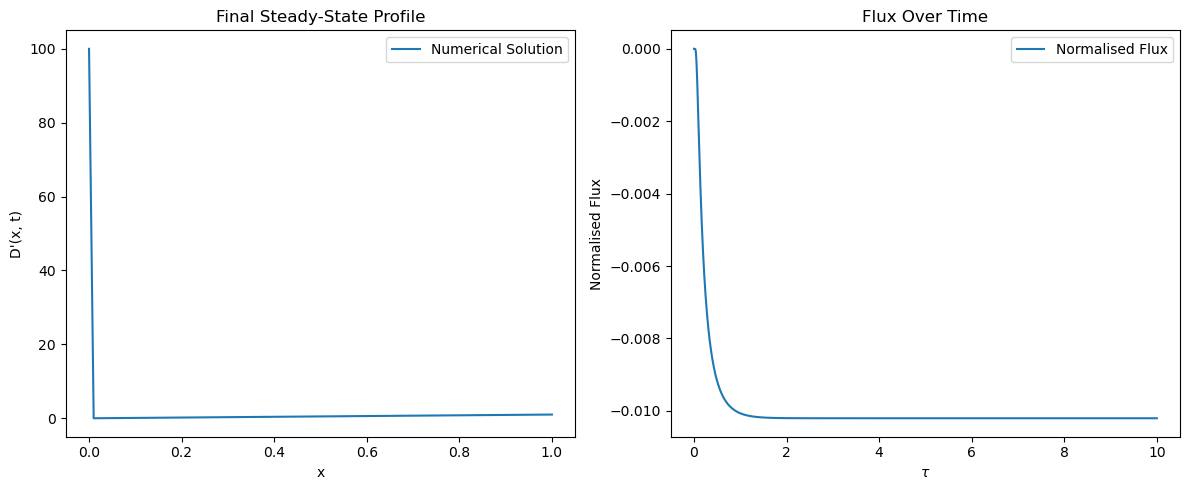

In [8]:
# Example call:
# Dprime_df, flux_df = _solve_pde_newton(D1_prime=10, DT_0=10e-7, T=1e3, X=1.0, L=0.1,
#                                       dt=0.01, dx=0.005)    # main settings
Dprime_df, flux_df = _solve_pde_newton(D1_prime=1, DT_0=10e-5, T=1e3, X=1.0, L=0.1,
                                      dt=0.01, dx=0.01)

x = [float(str(col).split('x=')[-1]) for col in Dprime_df.columns if 'x=' in col]

# Plot the final steady-state profile
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot final steady-state profile
axs[0].plot(x, Dprime_df.iloc[-1, :], label="Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("D'(x, t)")
axs[0].set_title("Final Steady-State Profile")
axs[0].legend()

# Plot flux history over time
axs[1].plot(flux_df['tau'], flux_df['normalised_flux'], label="Normalised Flux")
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel("Normalised Flux")
axs[1].set_title("Flux Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()

#### Iteration 3: Parallelsation

Because the time‐stepping is inherently sequential, you can’t parallelize across time steps. However, you can parallelize computation within each Newton iteration (for example, over the spatial domain) or run multiple parameter sweeps concurrently. One way is to use Numba’s parallel constructs. For instance, modifying the Newton inner loop to use prange.

In the code, the Newton update for each time‐step is performed in the JIT‑compiled function newton_step_parallel, which uses parallel loops to accelerate the residual and update computations.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from typing import Tuple
import numba as nb

@nb.njit(parallel=True)
def newton_step_parallel(D_old, dt, dx, K, tol, max_iter, D1_prime, D2_prime, relax):
    """
    Perform the Newton iteration for one time step in parallel.
    Uses Numba's prange to parallelize loops over the spatial grid.
    """
    N = D_old.shape[0]
    D_new = D_old.copy()
    inv_dx2 = 1.0 / (dx * dx)
    
    for it in range(max_iter):
        # Compute residual (R) for interior nodes in parallel.
        R = np.empty(N - 2, dtype=np.float64)
        for i in nb.prange(1, N - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2
            R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

        # Compute norms (using parallel loops with reductions).
        sumR = 0.0
        sumD = 0.0
        for i in nb.prange(1, N - 1):
            sumR += R[i-1] * R[i-1]
            sumD += D_new[i] * D_new[i]
        norm_R = np.sqrt(sumR)
        norm_D = np.sqrt(sumD)
        if norm_D == 0.0:
            norm_D = 1e-12

        if norm_R / norm_D < tol:
            break

        # Update interior nodes in parallel.
        for i in nb.prange(1, N - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2
            # Diagonal element of the Jacobian (naively approximated)
            J_diag = 1.0 / dt - K * ( (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2 
                                      + D_new[i] * (-2.0 * inv_dx2) )
            if J_diag == 0.0:
                J_diag = 1e-8
            D_new[i] = D_new[i] - relax * (R[i-1] / J_diag)
        
        # Reapply boundary conditions.
        D_new[0] = D1_prime
        D_new[N-1] = D2_prime
        
    return D_new

def _solve_pde_newton_parallel(D1_prime: float, DT_0: float, T: float, X: float, L: float,
                      dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0,
                      rel_tol: float = 1e-6, max_iter: int = 1000, relax: float = 0.5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Solve the nonlinear PDE:
         ∂D′/∂t = (DT₀/L²) · D′ · (∂²D′/∂x²)
    using an implicit time discretization with Newton's method.
    
    This version uses Numba's parallelization (prange) to speed up the innermost loops.
    """
    # Use double precision.
    dt = np.float64(dt)
    dx = np.float64(dx)
    
    if D1_prime <= 0 or D2_prime <= 0:
        raise ValueError("Boundary conditions must be positive")
    if D1_prime <= D2_prime:
        raise ValueError("D1_prime must be greater than D2_prime")
    
    # Grid setup.
    Nx = int(X / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, X, Nx, dtype=np.float64)
    t = np.linspace(0, T, Nt, dtype=np.float64)
    
    # Constant K from DT0/L^2.
    K = DT_0 / (L ** 2)
    
    # Initialize the solution array.
    D_prime = np.ones((Nt, Nx), dtype=np.float64)
    D_prime[:, 0] = D1_prime
    D_prime[:, -1] = D2_prime
    
    # Time stepping.
    pbar = tqdm(total=Nt - 1, desc=f"Newton PDE Solve (D1'={D1_prime}, DTO={DT_0})", ncols=100)
    for n in range(1, Nt):
        D_old = D_prime[n - 1].copy()
        D_new = newton_step_parallel(D_old, dt, dx, K, rel_tol, max_iter, D1_prime, D2_prime, relax)
        D_prime[n] = D_new.copy()
        pbar.update(1)
    pbar.close()
    
    # Compute normalized flux at the right boundary.
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create output DataFrames.
    Dprime_df = pd.DataFrame(D_prime, columns=[f"x={xi:.3f}" for xi in x], index=t)
    flux_df = pd.DataFrame({
        'time': t,
        'normalised_flux': F_norm,
        'tau': DT_0 * t / (L ** 2)
    })
    
    return Dprime_df, flux_df

In [ ]:
# Example call:
Dprime_df, flux_df = _solve_pde_newton_parallel(D1_prime=10, DT_0=10e-7, T=1e3, X=1.0, L=0.1,
                                                dt=0.01, dx=0.005)    # main settings

x = [float(str(col).split('x=')[-1]) for col in Dprime_df.columns if 'x=' in col]

# Plot the final steady-state profile
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot final steady-state profile
axs[0].plot(x, Dprime_df.iloc[-1, :], label="Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("D'(x, t)")
axs[0].set_title("Final Steady-State Profile")
axs[0].legend()

# Plot flux history over time
axs[1].plot(flux_df['tau'], flux_df['normalised_flux'], label="Normalised Flux")
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel("Normalised Flux")
axs[1].set_title("Flux Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()

Newton PDE Solve (D1'=10, DTO=1e-06):  15%|██▌              | 15063/100000 [02:23<09:57, 142.16it/s]

KeyboardInterrupt: 

Newton PDE Solve (D1'=10, DTO=1e-06):  15%|██▌              | 15078/100000 [02:40<09:57, 142.16it/s]

#### Iteration 4 (optional): Replacing Numpy with Cupy

Strategies to further speed up the computation without changing the underlying algorithm:
- GPU Acceleration – Offload heavy array operations (like the residual and Jacobian updates) to the GPU using libraries such as CuPy or Numba’s CUDA.
- Vectorization – Ensure that even the parts inside the inner loop are as vectorized as possible. For example, precompute repeated expressions outside of the loops and use fused arithmetic.
- Pre-allocation and Memory Management – Allocate arrays once and avoid creating new small arrays repeatedly inside loops to reduce memory overhead.

Code explanation:
- In this code we replace NumPy with CuPy for the heavy parts that compute the Laplacian, residual R, and Jacobian.
- The Newton iteration (inside newton_step_gpu) is written almost verbatim as before but now runs on the GPU.
- After stepping through all time steps, the resulting array is transferred back to CPU memory for further processing and plotting.

Using GPU acceleration (and fine-tuning your vectorization) can yield significant speedups—especially for large spatial grids—beyond what you achieved with CPU parallelization alone.

Cupy is built to work with CUDA, so it only runs on NVIDIA GPUs. Intel integrated GPUs do not support CUDA.

In [68]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from typing import Tuple

def newton_step_gpu(D_old, dt, dx, K, tol, max_iter, D1_prime, D2_prime, relax):
    """
    Perform the Newton iteration on GPU using CuPy arrays.
    """
    N = D_old.shape[0]
    D_new = D_old.copy()
    inv_dx2 = 1.0 / (dx*dx)
    
    for it in range(max_iter):
        # Compute residual R for interior nodes
        lapl = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) * inv_dx2
        R = (D_new[1:-1] - D_old[1:-1]) / dt - K * D_new[1:-1] * lapl

        norm_R = cp.linalg.norm(R, ord=2)
        norm_D = cp.linalg.norm(D_new[1:-1], ord=2)
        if norm_D == 0:
            norm_D = 1e-12
        if norm_R / norm_D < tol:
            break

        # Diagonal Jacobian approximation
        lapl_full = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) * inv_dx2
        J_diag = (1.0/dt) - K*(lapl_full + D_new[1:-1]*(-2.0*inv_dx2))
        J_diag[J_diag == 0] = 1e-8
        
        # Update solution (vectorized on GPU)
        D_new[1:-1] -= relax*(R/J_diag)

        # Reinforce boundary conditions
        D_new[0] = D1_prime
        D_new[-1] = D2_prime

    return D_new

def _solve_pde_newton_gpu(D1_prime: float, DT_0: float, T: float, X: float, L: float,
                          dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0,
                          rel_tol: float = 1e-6, max_iter: int = 1000, relax: float = 0.5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Solve the nonlinear PDE:
         ∂D′/∂t = (DT₀/L²) · D′ · (∂²D′/∂x²)
    using an implicit time discretization with Newton's method.
    
    This version uses CuPy to run the heavy calculations on the GPU.
    """
    # Ensure double precision
    dt = np.float64(dt)
    dx = np.float64(dx)
    
    # Setup grid and convert to Cupy arrays for GPU acceleration
    Nx = int(X/dx) + 1
    Nt = int(T/dt) + 1
    x = np.linspace(0, X, Nx)  # for plotting later on CPU
    t = np.linspace(0, T, Nt)

    # Constant K.
    K = DT_0 / (L**2)
    
    # Initialize solution (using Cupy for computation)
    D_prime_gpu = cp.ones((Nt, Nx), dtype=cp.float64)
    D_prime_gpu[:, 0] = D1_prime
    D_prime_gpu[:, -1] = D2_prime

    pbar = tqdm(total=Nt-1, desc="Newton PDE Solve (GPU)", ncols=100)
    for n in range(1, Nt):
        D_old = D_prime_gpu[n-1, :].copy()
        D_new = newton_step_gpu(D_old, dt, dx, K, rel_tol, max_iter, D1_prime, D2_prime, relax)
        D_prime_gpu[n, :] = D_new
        pbar.update(1)
    pbar.close()

    # Transfer results from GPU to CPU
    D_prime = cp.asnumpy(D_prime_gpu)
    # Compute normalized flux.
    F_norm = (-(D_prime[:, -1] - D_prime[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

    # Build DataFrames
    Dprime_df = pd.DataFrame(D_prime, columns=[f"x={xi:.3f}" for xi in x], index=t)
    flux_df = pd.DataFrame({
        'time': t,
        'normalised_flux': F_norm,
        'tau': DT_0 * t / (L**2)
    })

    return Dprime_df, flux_df

ModuleNotFoundError: No module named 'cupy'

#### Iteration 5: Numba-JIT with adaptive time-stepping scheme

Strategy:
Before starting the simulation the code compares dt with a stability‐based factor (using dx²) and then—if a Newton iteration fails to converge within max_iter—the time step is reduced automatically and the current step is retried. This adaptive mechanism adjusts dt (and issues a warning if dt is too large) without changing the underlying Newton–JIT algorithm.

Code explanation:
- At the start of the solver function, we compare the current dt to a stability bound (here chosen as 0.5⋅dx²). If dt is too large, it is reduced accordingly.
- Within the time-stepping loop, if the Newton iteration does not converge (as signaled by our flag "converged" from the JIT routine), the step is retried with a halved dt until convergence is reached (or until a minimum dt is hit).
- The solution, time grid, and corresponding flux values are stored and then returned via Pandas DataFrames.

This adaptive approach uses run-time detection to adjust dt (and indirectly the effective CFL-like condition with dx) automatically without changing the core Newton–JIT algorithm, thereby reducing round-off or truncation error issues associated with extreme dt or dx values.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from typing import Tuple
import numba as nb

# -------------------------------------------------------------------
# JIT-compiled Newton step with parallelization.
@nb.njit(parallel=True)
def newton_step_parallel(D_old, dt, dx, K, tol, max_iter, D1_prime, D2_prime, relax):
    """
    Perform the Newton iteration for one time step (for the interior nodes) and return:
      D_new: the updated solution,
      converged: flag (1 if convergence reached, 0 otherwise),
      iter_used: number of iterations used.
    """
    N = D_old.shape[0]
    D_new = D_old.copy()
    inv_dx2 = 1.0 / (dx * dx)
    iter_used = 0
    converged = 0
    for it in range(max_iter):
        iter_used = it
        # Compute residual R for interior points.
        R = np.empty(N - 2, dtype=np.float64)
        for i in nb.prange(1, N - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2
            R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

        # Compute L2 norms (using reductions).
        sumR = 0.0
        sumD = 0.0
        for i in nb.prange(N - 2):
            sumR += R[i] * R[i]
        for i in nb.prange(1, N - 1):
            sumD += D_new[i] * D_new[i]
        norm_R = np.sqrt(sumR)
        norm_D = np.sqrt(sumD)
        if norm_D == 0.0:
            norm_D = 1e-12

        # Check convergence using a relative tolerance.
        if norm_R / norm_D < tol:
            converged = 1
            break

        # Update interior nodes using a diagonal Jacobian approximation.
        for i in nb.prange(1, N - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2
            J_diag = 1.0/dt - K * ((D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) * inv_dx2 +
                                   D_new[i] * (-2.0 * inv_dx2))
            if J_diag == 0.0:
                J_diag = 1e-8
            D_new[i] = D_new[i] - relax * (R[i-1] / J_diag)
        # Reapply boundary conditions.
        D_new[0] = D1_prime
        D_new[N-1] = D2_prime
    return D_new, converged, iter_used + 1  # iter_used+1 for 1-indexed iteration count

# -------------------------------------------------------------------
def _solve_pde_newton_parallel_adaptive(
    D1_prime: float, DT_0: float, T: float, X: float, L: float,
    dt: float, dx: float, U_VprimeW: float = None, D2_prime: float = 1.0,
    rel_tol: float = 1e-6, max_iter: int = 10, relax: float = 0.5,
    dt_min: float = 1e-6
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Solve the nonlinear PDE:
         ∂D′/∂t = (DT₀/L²) · D′ · (∂²D′/∂x²)
    using an implicit Newton method with adaptive dt.

    This version only updates dt (reducing it) if numerical instability (lack of convergence)
    is detected.
    """
    # Stability check: For central differences, a rough guideline is dt <= stability_factor * dx².
    stability_factor = 0.5
    dt_max_allowed = stability_factor * dx**2
    if dt > dt_max_allowed:
        print(f"Warning: Initial dt={dt} > {dt_max_allowed} (stability limit). Setting dt={dt_max_allowed}.")
        dt = dt_max_allowed

    # Grid setup.
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx, dtype=np.float64)
    
    # Constant K = DT_0 / L².
    K = DT_0 / (L**2)
    
    # Initialize the solution list.
    D_prime = []
    D0 = np.ones(Nx, dtype=np.float64)
    D0[0] = D1_prime
    D0[-1] = D2_prime
    D_prime.append(D0.copy())
    
    # Time-tracking.
    t_vals = [0.0]
    current_t = 0.0

    pbar = tqdm(total=T, desc="Adaptive Newton PDE Solve", ncols=100)
    while current_t < T:
        D_old = D_prime[-1].copy()
        accepted = False
        trial_dt = dt
        # Attempt the Newton step; if not converged, reduce dt and retry.
        while not accepted:
            D_new, converged, iter_count = newton_step_parallel(
                D_old, trial_dt, dx, K, rel_tol, max_iter, D1_prime, D2_prime, relax
            )
            if not converged:
                trial_dt *= 0.5
                if trial_dt < dt_min:
                    raise RuntimeError("Time step dt became too small; simulation fails to converge.")
            else:
                accepted = True
        # Only update dt if instability was detected.
        if trial_dt < dt:
            dt = trial_dt
        current_t += dt
        t_vals.append(current_t)
        D_prime.append(D_new.copy())
        pbar.update(dt)
    pbar.close()

    # Convert results to NumPy array.
    D_prime_arr = np.array(D_prime)
    t_arr = np.array(t_vals)

    # Compute the normalized flux at the right boundary.
    F_norm = (-(D_prime_arr[:, -1] - D_prime_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

    # Create output DataFrames.
    Dprime_df = pd.DataFrame(D_prime_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
    flux_df = pd.DataFrame({
        'time': t_arr,
        'normalised_flux': F_norm,
        'tau': DT_0 * t_arr / (L**2)
    })
    
    return Dprime_df, flux_df

In [9]:
# Example call:
Dprime_df, flux_df = _solve_pde_newton_parallel_adaptive(D1_prime=5, DT_0=1e-7, T=40e3, X=1.0, L=0.1,
                                                         dt=0.1, dx=0.005)

x = [float(str(col).split('x=')[-1]) for col in Dprime_df.columns if 'x=' in col]

# Plot the final steady-state profile
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot final steady-state profile
axs[0].plot(x, Dprime_df.iloc[-1, :], label="Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("D'(x, t)")
axs[0].set_title("Final Steady-State Profile")
axs[0].legend()

# Plot flux history over time
axs[1].plot(flux_df['tau'], flux_df['normalised_flux'], label="Normalised Flux")
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel("Normalised Flux")
axs[1].set_title("Flux Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()

RuntimeError: Time step dt became too small; simulation fails to converge.

#### Iteration 6: Numba-JIT with adaptive dt selection
Explanation:
- The function starts by enforcing a rough stability limit (dt ≤ 0.5·dx²) and then builds the spatial grid.
- In the main while‑loop (until current_t reaches T), each time step is performed by trying Newton iterations with the current trial_dt.
- If the resulting residual is too high (Newton fails to converge), dt is halved and the current step is retried.
- If convergence is achieved, the accepted dt is used to update the current time and the solution is stored.
- A tqdm progress bar (pbar) is updated by the dt value for each accepted step, so it reflects the cumulative simulated time.

This adaptive scheme allows the solver to automatically select a dt that provides numerical stability throughout the simulation without changing the underlying discretization or Newton method.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numba as nb

@nb.njit
def newton_update_jit(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
    """
    JIT-compiled helper to perform Newton iterations for one time step.
    Returns the updated solution D_new and a convergence flag (1 if converged, else 0).
    """
    D_new = D_old.copy()
    Nx = D_old.shape[0]
    converged = 0
    dx2 = dx * dx
    for it in range(max_iter):
        R = np.empty(Nx - 2, dtype=np.float64)
        # Compute residual for interior nodes.
        for i in range(1, Nx - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
            R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

        # Compute L2 norms.
        sumR = 0.0
        sumD = 0.0
        for i in range(Nx - 2):
            sumR += R[i] * R[i]
        for i in range(1, Nx - 1):
            sumD += D_new[i] * D_new[i]
        norm_R = np.sqrt(sumR)
        norm_D = np.sqrt(sumD)
        if norm_D == 0.0:
            norm_D = 1e-12

        if norm_R / norm_D < rel_tol:
            converged = 1
            break

        # Newton update for interior nodes using a diagonal Jacobian.
        for i in range(1, Nx - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
            J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[i]) / dx2)
            if J_diag == 0.0:
                J_diag = 1e-8
            D_new[i] = D_new[i] - relax * (((D_new[i] - D_old[i]) / dt) - K * D_new[i] * lapl) / J_diag

        # Enforce boundary conditions.
        D_new[0] = D1_prime
        D_new[Nx - 1] = D2_prime
    return D_new, converged

def solve_pde_newton_adaptive(D1_prime, DT_0, T, X, L, dx, 
                              D2_prime=1.0, rel_tol=1e-6, max_iter=10, relax=0.5,
                              dt_init=0.0001, dt_target=10, dt_min=1e-6, ramp_up_factor=1.1):
    """
    Adaptive implicit PDE solver using Newton's method with a dt ramp-up strategy.
    
    Parameters:
      dt_init       : initial time step (user-specified; no stability bound is enforced)
      dt_target     : desired (larger) time step for later in the simulation
      ramp_up_factor: factor to multiply dt after each successful step, up to dt_target
      
    The full time-history is stored and returned as two DataFrames:
      • Dprime_df: solution at each time step (rows indexed by time)
      • flux_df  : normalized flux computed at every time step
    
    Returns:
      Dprime_df, flux_df
    """
    # Spatial grid.
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx)
    # Compute constant K.
    K = DT_0 / (L * L)
    
    # Initial condition.
    D0 = np.ones(Nx, dtype=np.float64)
    D0[0] = D1_prime
    D0[-1] = D2_prime

    # Initialize history lists.
    t_history = [0.0]
    D_history = [D0.copy()]
    current_t = 0.0
    dt = dt_init

    pbar = tqdm(total=T, desc="Adaptive PDE Solve", ncols=100)
    while current_t < T:
        accepted = False
        trial_dt = dt
        # Attempt a Newton update; if update fails to converge, reduce dt.
        while not accepted:
            D_new, converged = newton_update_jit(D_history[-1], trial_dt, dx, K,
                                                 max_iter, D1_prime, D2_prime, relax, rel_tol)
            if converged == 1:
                accepted = True
            else:
                trial_dt *= 0.5
                if trial_dt < dt_min:
                    raise RuntimeError("dt became too small; simulation fails to converge.")
                # print("Reducing dt to", trial_dt)
        # Use ramp-up strategy if dt is below target.
        if trial_dt < dt_target:
            new_dt = min(trial_dt * ramp_up_factor, dt_target)
            # if new_dt > trial_dt:
                # print("Increasing dt from", trial_dt, "to", new_dt)
            dt = new_dt
        else:
            dt = trial_dt
        current_t += dt
        t_history.append(current_t)
        D_history.append(D_new.copy())
        pbar.update(dt)
    pbar.close()

    # Convert history lists to arrays.
    D_arr = np.array(D_history)
    t_arr = np.array(t_history)
    # Compute normalized flux at the right boundary for each time step.
    F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Export the solution history and flux history as DataFrames.
    Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
    flux_df = pd.DataFrame({
        "time": t_arr,
        "normalised_flux": F_norm,
        "tau": DT_0 * t_arr / (L * L)
    })

    return Dprime_df, flux_df

In [38]:
# Example call:
Dprime_df, flux_df = solve_pde_newton_adaptive(
        D1_prime=100.0, DT_0=1e-6, T=10e3, X=1.0, L=0.1,
        dx=0.0002, rel_tol=1e-6, max_iter=100, relax=0.8
    )

x = [float(str(col).split('x=')[-1]) for col in Dprime_df.columns if 'x=' in col]

# Plot the final steady-state profile
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot final steady-state profile
axs[0].plot(x, Dprime_df.iloc[-1, :], label="Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("D'(x, t)")
axs[0].set_title("Final Steady-State Profile")
axs[0].legend()

# Plot flux history over time
axs[1].plot(flux_df['tau'], flux_df['normalised_flux'], label="Normalised Flux")
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel("Normalised Flux")
axs[1].set_title("Flux Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

KeyboardInterrupt: 

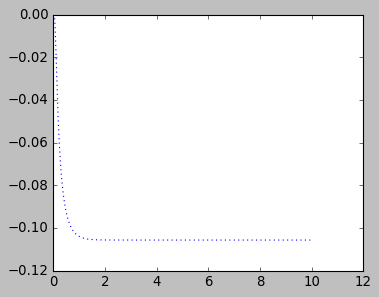

In [32]:
# Test different parameter combinations
DT_0s = [1e-5, 1e-6]  # Range of DT_0 values
D1_primes = [10, 50, 100]  # Range of D1_prime values

# Create figure
plt.figure(figsize=(5, 4))
plt.style.use('classic')

# Color map for D1_prime and line styles for DT_0
colors = ['b', 'g', 'r']
styles = [':', '--', '-']

# Test all combinations
for i, D1_prime in enumerate(D1_primes):
    for j, DT_0 in enumerate(DT_0s):        
        _, flux_df = solve_pde_newton_adaptive(D1_prime=D1_prime, DT_0=DT_0, T=10e3, X=1.0, L=0.1,
                                               dx=0.0005, rel_tol=1e-4, max_iter=100, relax=0.8)
         
        plt.plot(flux_df['tau'], flux_df['normalised_flux'], 
                color=colors[i], linestyle=styles[j],
                label=f'D1_prime={D1_prime:.1f}, DT_0={DT_0:.1e}')

plt.xlabel(r'$\tau$ (Dimensionless Time)')
plt.ylabel('Normalised Flux')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.show()

#### Iteration 7: Numba-JIT with adaptive dt (with fallback mode)

Instead of raising an error when trial_dt becomes too small, the code now switches to a fallback mode—in this example, it forces dt to dt_min and increases the damping (reduces relax) to help achieve convergence. You can adjust the fallback strategy as needed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numba as nb

@nb.njit
def newton_update_jit(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
    """
    JIT-compiled helper to perform Newton iterations for one time step.
    Returns updated solution D_new and a convergence flag (1 if converged, else 0).
    """
    D_new = D_old.copy()
    Nx = D_old.shape[0]
    converged = 0
    dx2 = dx * dx
    for it in range(max_iter):
        R = np.empty(Nx - 2, dtype=np.float64)
        for i in range(1, Nx - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
            R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

        sumR = 0.0
        sumD = 0.0
        for i in range(Nx - 2):
            sumR += R[i] * R[i]
        for i in range(1, Nx - 1):
            sumD += D_new[i] * D_new[i]
        norm_R = np.sqrt(sumR)
        norm_D = np.sqrt(sumD)
        if norm_D == 0.0:
            norm_D = 1e-12

        if norm_R / norm_D < rel_tol:
            converged = 1
            break

        for i in range(1, Nx - 1):
            lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
            J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[i]) / dx2)
            if J_diag == 0.0:
                J_diag = 1e-8
            D_new[i] = D_new[i] - relax * (((D_new[i] - D_old[i]) / dt) - K * D_new[i] * lapl) / J_diag

        D_new[0] = D1_prime
        D_new[Nx - 1] = D2_prime
    return D_new, converged

def solve_pde_newton_adaptive_fallback(D1_prime, DT_0, T, X, L, dx, 
                              D2_prime=1.0, rel_tol=1e-6, max_iter=10, relax=0.8,
                              dt_init=0.0001, dt_target=10, dt_min=1e-6, dt_ramp_factor=1.1):
    """
    Adaptive implicit PDE solver using Newton's method with adaptive dt.
    Instead of stopping the simulation when dt becomes too small,
    the solver switches to fallback mode: dt is fixed to dt_min and damping is increased.
    
    Returns:
      Dprime_df, flux_df (solution history and flux history as DataFrames)
    """
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx)
    K = DT_0 / (L * L)
    D0 = np.ones(Nx, dtype=np.float64)
    D0[0] = D1_prime
    D0[-1] = D2_prime

    t_history = [0.0]
    D_history = [D0.copy()]
    current_t = 0.0
    dt = dt_init

    pbar = tqdm(total=T, desc="Adaptive PDE Solve", ncols=100)
    while current_t < T:
        accepted = False
        trial_dt = dt
        current_relax = relax  # start with the original relaxation
        while not accepted:
            D_new, converged = newton_update_jit(D_history[-1], trial_dt, dx, K,
                                                 max_iter, D1_prime, D2_prime, current_relax, rel_tol)
            if converged == 1:
                accepted = True
            else:
                trial_dt *= 0.5
                # print("Reducing dt to", trial_dt)
                # Instead of stopping, if trial_dt drops below dt_min, switch to fallback.
                if trial_dt < dt_min:
                    # print("dt has reached the minimum threshold. Switching to dt_min and increasing damping.")
                    trial_dt = dt_min
                    current_relax = current_relax * 0.5  # increase damping
        if trial_dt < dt_target:
            new_dt = min(trial_dt * dt_ramp_factor, dt_target)
            # if new_dt > trial_dt:
            #     print("Increasing dt from", trial_dt, "to", new_dt)
            dt = new_dt
        else:
            dt = trial_dt
        current_t += dt
        t_history.append(current_t)
        D_history.append(D_new.copy())
        pbar.update(dt) # increments the progress by an amount dt
    pbar.close()

    D_arr = np.array(D_history)
    t_arr = np.array(t_history)
    F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
    flux_df = pd.DataFrame({
        "time": t_arr,
        "normalised_flux": F_norm,
        "tau": DT_0 * t_arr / (L * L)
    })

    return Dprime_df, flux_df

Adaptive PDE Solve: 80006.10377660347it [00:11, 6776.78it/s]                                        


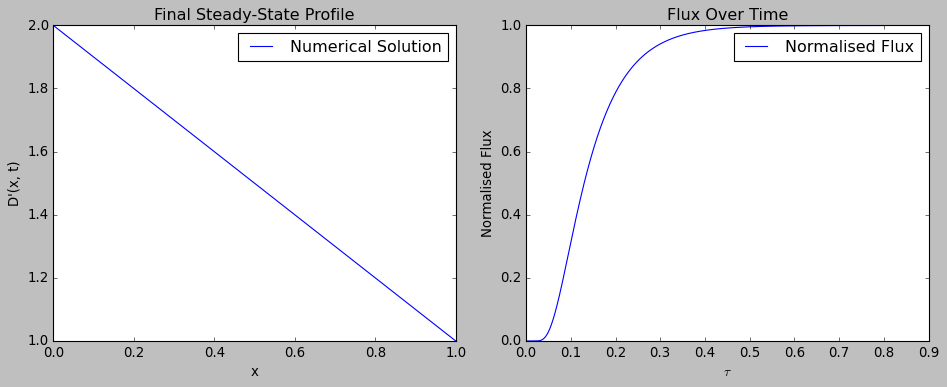

In [12]:
# Example call:
# Dprime_df, flux_df = solve_pde_newton_adaptive_fallback(
#         D1_prime=2.0, DT_0=5e-5, T=10e3, X=1.0, L=0.1,
#         dx=0.005, rel_tol=1e-6, max_iter=100, relax=0.8
#     )
# Dprime_df, flux_df = solve_pde_newton_adaptive_fallback(
#         D1_prime=2.0, DT_0=1e-7, T=80e3, X=1.0, L=0.1,
#         dx=0.005, rel_tol=1e-6, max_iter=100, relax=0.8, dt_target=5
#     ) # norm_flux not reaching 1.0
Dprime_df, flux_df = solve_pde_newton_adaptive_fallback(
        D1_prime=2.0, DT_0=1e-7, T=80e3, X=1.0, L=0.1,
        dx=0.002, rel_tol=1e-8, max_iter=100, relax=0.8, dt_target=10
    )   # decreasing r_tol and increase max_iter helps norm_flux to reach 1.0

x = [float(str(col).split('x=')[-1]) for col in Dprime_df.columns if 'x=' in col]

plt.style.use('classic')
# Plot the final steady-state profile
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot final steady-state profile
axs[0].plot(x, Dprime_df.iloc[-1, :], label="Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("D'(x, t)")
axs[0].set_title("Final Steady-State Profile")
axs[0].legend()

# Plot flux history over time
axs[1].plot(flux_df['tau'], flux_df['normalised_flux'], label="Normalised Flux")
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel("Normalised Flux")
axs[1].set_title("Flux Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()

Adaptive PDE Solve: 1001.6988445210472it [00:00, 6716.95it/s]                                       
Adaptive PDE Solve: 1004.3937161745982it [00:00, 1314.73it/s]                                       
Adaptive PDE Solve:  97%|█████████████████████▍| 973.3847428986653/1000.0 [00:00<00:00, 1512.06it/s]c:\Users\sieun\anaconda3\envs\permeationenv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Adaptive PDE Solve: 100%|█████████████████████| 1000.0286063214114/1000.0 [00:00<00:00, 1392.17it/s]
Adaptive PDE Solve: 1009.8815644876468it [00:01, 556.48it/s]                                        
Adaptive PDE Solve: 1003.5588804713615it [00:02, 364.11it/s]                                        
Adaptive PDE Solve: 1009.8620711122169it [00:04, 243.69it/s]                                        


<Figure size 400x320 with 0 Axes>

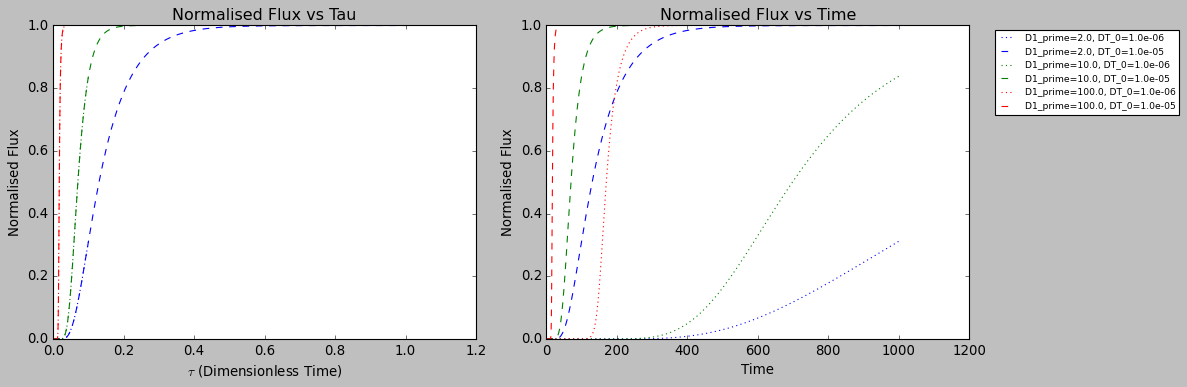

In [13]:
# Test different parameter combinations
DT_0s = [1e-6, 1e-5]  # Range of DT_0 values
D1_primes = [2, 10, 100]  # Range of D1_prime values

# Create figure
plt.figure(figsize=(5, 4))
plt.style.use('classic')

# Color map for D1_prime and line styles for DT_0
colors = ['b', 'g', 'r']
styles = [':', '--', '-']

# Test all combinations
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, D1_prime in enumerate(D1_primes):
    for j, DT_0 in enumerate(DT_0s):        
        _, flux_df = solve_pde_newton_adaptive_fallback(
            D1_prime=D1_prime, DT_0=DT_0, T=1e3, X=1.0, L=0.1,
            dx=0.005, rel_tol=1e-6, max_iter=100, relax=0.8
        )
        
        axs[0].plot(
            flux_df['tau'], flux_df['normalised_flux'],
            color=colors[i], linestyle=styles[j],
            label=f'D1_prime={D1_prime:.1f}, DT_0={DT_0:.1e}'
        )
        axs[1].plot(
            flux_df['time'], flux_df['normalised_flux'],
            color=colors[i], linestyle=styles[j],
            label=f'D1_prime={D1_prime:.1f}, DT_0={DT_0:.1e}'
        )

axs[0].set_xlabel(r'$\tau$ (Dimensionless Time)')
axs[0].set_ylabel('Normalised Flux')
axs[0].set_title('Normalised Flux vs Tau')
# axs[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

axs[1].set_xlabel('Time')
axs[1].set_ylabel('Normalised Flux')
axs[1].set_title('Normalised Flux vs Time')
axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize='x-small')

plt.tight_layout()
plt.show()

### Comparing diagonal and full Jacobian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba as nb
import time


def compare_jacobian_methods(D1_prime=2.0, DT_0=1e-7, T=10e3, X=1.0, L=0.1, dx=0.005, dt=0.01,
                             rel_tol=1e-8, max_iter=100, relax=0.8):
    """
    Compares the diagonal and full Jacobian methods for solving a PDE using Newton's method.
    """

    # --- Helper Functions (JIT-compiled) ---
    @nb.njit
    def _newton_update_jit_diagonal(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
        """Newton iterations with diagonal Jacobian."""
        D_new = D_old.copy()
        Nx = D_old.shape[0]
        converged = 0
        dx2 = dx * dx
        for it in range(max_iter):
            R = np.empty(Nx - 2, dtype=np.float64)
            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

            sumR = 0.0
            sumD = 0.0
            for i in range(Nx - 2):
                sumR += R[i] * R[i]
            for i in range(Nx - 1):
                sumD += D_new[i] * D_new[i]
            norm_R = np.sqrt(sumR)
            norm_D = np.sqrt(sumD)
            if norm_D == 0.0:
                norm_D = 1e-12

            if norm_R / norm_D < rel_tol:
                converged = 1
                break

            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[i]) / dx2)
                if J_diag == 0.0:
                    J_diag = 1e-8
                D_new[i] = D_new[i] - relax * (((D_new[i] - D_old[i]) / dt) - K * D_new[i] * lapl) / J_diag

        D_new[0] = D1_prime
        D_new[Nx - 1] = D2_prime
        return D_new, converged

    @nb.njit
    def _newton_update_jit_full(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
        """Newton iterations with full (tridiagonal) Jacobian."""
        D_new = D_old.copy()
        Nx = D_old.shape[0]
        converged = 0
        dx2 = dx * dx
        for it in range(max_iter):
            R = np.empty(Nx - 2, dtype=np.float64)
            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

            sumR = 0.0
            sumD = 0.0
            for i in range(Nx - 2):
                sumR += R[i] * R[i]
            for i in range(Nx - 1):
                sumD += D_new[i] * D_new[i]
            norm_R = np.sqrt(sumR)
            norm_D = np.sqrt(sumD)
            if norm_D == 0.0:
                norm_D = 1e-12

            if norm_R / norm_D < rel_tol:
                converged = 1
                break

            # Solve the tridiagonal system J * update = -R
            J_diag = np.zeros(Nx-2)
            J_lower = np.zeros(Nx-3)
            J_upper = np.zeros(Nx-3)

            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2

                # Diagonal elements
                J_diag[i-1] = (1.0 / dt) - K * (lapl + (-2.0 * D_new[i]) / dx2)

                # Off-diagonal elements
                if i > 1:
                    J_lower[i-2] = K * D_new[i-1] / dx2
                if i < Nx - 2:
                    J_upper[i-1] = K * D_new[i+1] / dx2

            update = solve_tridiagonal(J_lower, J_diag, J_upper, -R)

            # Update the solution
            for i in range(1, Nx - 1):
                D_new[i] += relax * update[i-1]

        D_new[0] = D1_prime
        D_new[Nx - 1] = D2_prime
        return D_new, converged

    @nb.njit
    def solve_tridiagonal(a, b, c, d):
        """Solve a tridiagonal system Ax = d using the Thomas algorithm."""
        nf = d.shape[0]
        ac, bc, cc, dc = a.copy(), b.copy(), c.copy(), d.copy()
        for it in range(1, nf):
            mc = ac[it-1]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1]
            dc[it] = dc[it] - mc*dc[it-1]

        xc = np.zeros_like(bc)
        xc[-1] = dc[-1]/bc[-1]

        for il in range(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
        return xc

    # --- PDE Solving Functions ---

    def _solve_pde_diagonal(D1_prime, DT_0, T, X, L, dx,
                      D2_prime=1.0, rel_tol=1e-8, max_iter=100, relax=0.8,
                      dt_init=0.0005, dt_target=10, dt_min=1e-6, dt_ramp_factor=1.1):
        """Adaptive implicit PDE solver using Newton's method with diagonal Jacobian."""
        Nx = int(X / dx) + 1
        x = np.linspace(0, X, Nx)
        K = DT_0 / (L * L)
        D0 = np.ones(Nx, dtype=np.float64)
        D0[0] = D1_prime
        D0[-1] = D2_prime

        t_history = [0.0]
        D_history = [D0.copy()]
        current_t = 0.0
        dt = dt_init

        while current_t < T:
            accepted = False
            trial_dt = dt
            current_relax = relax
            while not accepted:
                D_new, converged = _newton_update_jit_diagonal(D_history[-1], trial_dt, dx, K,
                                                    max_iter, D1_prime, D2_prime, current_relax, rel_tol)
                if converged == 1:
                    accepted = True
                else:
                    trial_dt *= 0.5
                    if trial_dt < dt_min:
                        trial_dt = dt_min
                        current_relax = current_relax * 0.5
            if trial_dt < dt_target:
                new_dt = min(trial_dt * dt_ramp_factor, dt_target)
                dt = new_dt
            else:
                dt = trial_dt
            current_t += dt
            t_history.append(current_t)
            D_history.append(D_new.copy())

        D_arr = np.array(D_history)
        t_arr = np.array(t_history)
        F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

        Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
        flux_df = pd.DataFrame({
            "time": t_arr,
            "normalised_flux": F_norm,
            "tau": DT_0 * t_arr / (L * L)
        })

        return Dprime_df, flux_df

    def _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                      D2_prime=1.0, rel_tol=1e-8, max_iter=100, relax=0.8,
                      dt_init=0.0005, dt_target=10, dt_min=1e-6, dt_ramp_factor=1.1):
        """Adaptive implicit PDE solver using Newton's method with full Jacobian."""
        Nx = int(X / dx) + 1
        x = np.linspace(0, X, Nx)
        K = DT_0 / (L * L)
        D0 = np.ones(Nx, dtype=np.float64)
        D0[0] = D1_prime
        D0[-1] = D2_prime

        t_history = [0.0]
        D_history = [D0.copy()]
        current_t = 0.0
        dt = dt_init

        while current_t < T:
            accepted = False
            trial_dt = dt
            current_relax = relax
            while not accepted:
                D_new, converged = _newton_update_jit_full(D_history[-1], trial_dt, dx, K,
                                                    max_iter, D1_prime, D2_prime, current_relax, rel_tol)
                if converged == 1:
                    accepted = True
                else:
                    trial_dt *= 0.5
                    if trial_dt < dt_min:
                        trial_dt = dt_min
                        current_relax = current_relax * 0.5
            if trial_dt < dt_target:
                new_dt = min(trial_dt * dt_ramp_factor, dt_target)
                dt = new_dt
            else:
                dt = trial_dt
            current_t += dt
            t_history.append(current_t)
            D_history.append(D_new.copy())

        D_arr = np.array(D_history)
        t_arr = np.array(t_history)
        F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

        Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
        flux_df = pd.DataFrame({
            "time": t_arr,
            "normalised_flux": F_norm,
            "tau": DT_0 * t_arr / (L * L)
        })

        return Dprime_df, flux_df

    # --- Solve and Compare ---

# Solve PDE using diagonal Jacobian
    start_time_diag = time.time()
    Dprime_df_diag, flux_df_diag = _solve_pde_diagonal(D1_prime, DT_0, T, X, L, dx,
                                              rel_tol=rel_tol, max_iter=max_iter, relax=relax)
    end_time_diag = time.time()
    time_diag = end_time_diag - start_time_diag

    # Solve PDE using full Jacobian
    start_time_full = time.time()
    Dprime_df_full, flux_df_full = _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                                              rel_tol=rel_tol, max_iter=max_iter, relax=relax)
    end_time_full = time.time()
    time_full = end_time_full - start_time_full

    # --- Plotting ---

    x_values = [float(col[2:]) for col in Dprime_df_diag.columns]

    plt.figure(figsize=(12, 6))
    plt.plot(x_values, Dprime_df_diag.iloc[-1, :], label="Diagonal Jacobian")
    plt.plot(x_values, Dprime_df_full.iloc[-1, :], label="Full Jacobian")
    plt.xlabel("x")
    plt.ylabel("D'(x, t)")
    plt.title("Comparison of Steady-State Profiles")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(flux_df_diag["time"], flux_df_diag["normalised_flux"], label="Diagonal Jacobian")
    plt.plot(flux_df_full["time"], flux_df_full["normalised_flux"], label="Full Jacobian")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.title("Comparison of Flux Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Time taken for Diagonal Jacobian: {time_diag:.4f} seconds")
    print(f"Time taken for Full Jacobian: {time_full:.4f} seconds")

# --- Example Usage ---
compare_jacobian_methods()

KeyboardInterrupt: 

With speed improvement.
Key optimizations in this version:

Vectorized Operations:
- Residual calculation is vectorized using NumPy operations
- Jacobian calculation uses vectorized operations where possible
- Norm calculations use np.dot for better performance

Optimized Tridiagonal Solver:
- Uses a more efficient implementation of the Thomas algorithm
- Pre-allocates arrays to avoid repeated memory allocation
- Uses direct memory access patterns for better cache performance

JIT Compilation:
- All numerical operations are JIT-compiled with Numba
- Added warm-up call to trigger JIT compilation before timing
- Uses @nb.njit for maximum performance

Memory Management:
- Minimizes array copying and temporary array creation
- Uses in-place operations where possible
- Pre-allocates arrays for better memory efficiency

Performance Measurement:
- Uses time.perf_counter() for high-precision timing
- Reports computation time in seconds

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba as nb
import time


def compare_jacobian_methods(D1_prime=2.0, DT_0=1e-7, T=10e3, X=1.0, L=0.1, dx=0.005, dt=0.01,
                             rel_tol=1e-8, max_iter=100, relax=0.8):
    """
    Compares the diagonal and full Jacobian methods for solving a PDE using Newton's method.
    """

    # --- Helper Functions (JIT-compiled) ---
    @nb.njit
    def _newton_update_jit_diagonal(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
        """Newton iterations with diagonal Jacobian."""
        D_new = D_old.copy()
        Nx = D_old.shape[0]
        converged = 0
        dx2 = dx * dx
        for it in range(max_iter):
            R = np.empty(Nx - 2, dtype=np.float64)
            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

            sumR = 0.0
            sumD = 0.0
            for i in range(Nx - 2):
                sumR += R[i] * R[i]
            for i in range(Nx - 1):
                sumD += D_new[i] * D_new[i]
            norm_R = np.sqrt(sumR)
            norm_D = np.sqrt(sumD)
            if norm_D == 0.0:
                norm_D = 1e-12

            if norm_R / norm_D < rel_tol:
                converged = 1
                break

            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[i]) / dx2)
                if J_diag == 0.0:
                    J_diag = 1e-8
                D_new[i] = D_new[i] - relax * (((D_new[i] - D_old[i]) / dt) - K * D_new[i] * lapl) / J_diag

        D_new[0] = D1_prime
        D_new[Nx - 1] = D2_prime
        return D_new, converged

    @nb.njit
    def _calculate_residual(D_new, D_old, dt, dx, K):
        """Vectorized residual calculation for interior points."""
        dx2 = dx * dx
        lapl = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) / dx2
        R = (D_new[1:-1] - D_old[1:-1]) / dt - K * D_new[1:-1] * lapl
        return R

    @nb.njit
    def _calculate_jacobian(D_new, dt, dx, K, Nx):
        """Calculate the Jacobian matrix elements."""
        dx2 = dx * dx
        J_diag = np.zeros(Nx - 2)
        J_lower = np.zeros(Nx - 3)
        J_upper = np.zeros(Nx - 3)

        # Vectorized Laplacian calculation
        lapl = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) / dx2
        
        # Diagonal elements
        J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[1:-1]) / dx2)
        
        # Off-diagonal elements
        J_lower = K * D_new[1:-2] / dx2
        J_upper = K * D_new[2:-1] / dx2
        
        return J_diag, J_lower, J_upper

    @nb.njit
    def _solve_tridiagonal(a, b, c, d):
        """Optimized Thomas algorithm for tridiagonal systems."""
        n = d.shape[0]
        x = np.zeros_like(d)
        
        # Forward sweep - modified Thomas algorithm
        c_prime = np.zeros_like(c)
        d_prime = np.zeros_like(d)
        
        c_prime[0] = c[0] / b[0]
        d_prime[0] = d[0] / b[0]
        
        for i in range(1, n):
            m = 1.0 / (b[i] - a[i-1] * c_prime[i-1])
            c_prime[i] = c[i] * m if i < n-1 else 0.0
            d_prime[i] = (d[i] - a[i-1] * d_prime[i-1]) * m
        
        # Back substitution
        x[-1] = d_prime[-1]
        for i in range(n-2, -1, -1):
            x[i] = d_prime[i] - c_prime[i] * x[i+1]
        
        return x

    @nb.njit
    def _newton_update_jit_full(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
        """Optimized Newton iterations with full Jacobian."""
        D_new = D_old.copy()
        Nx = D_old.shape[0]
        converged = 0
        dx2 = dx * dx
        
        for it in range(max_iter):
            # Compute residual
            R = _calculate_residual(D_new, D_old, dt, dx, K)
            
            # Fast norm calculations using np.dot
            norm_R = np.sqrt(np.dot(R, R))
            norm_D = np.sqrt(np.dot(D_new[1:-1], D_new[1:-1]))
            
            if norm_D == 0.0:
                norm_D = 1e-12

            if norm_R / norm_D < rel_tol:
                converged = 1
                break

            # Calculate Jacobian and solve system
            J_diag, J_lower, J_upper = _calculate_jacobian(D_new, dt, dx, K, Nx)
            update = _solve_tridiagonal(J_lower, J_diag, J_upper, -R)
            
            # Update solution with vectorized operation
            D_new[1:-1] += relax * update
            D_new[0] = D1_prime
            D_new[-1] = D2_prime

        return D_new, converged

    # --- PDE Solving Functions ---

    def _solve_pde_diagonal(D1_prime, DT_0, T, X, L, dx,
                      D2_prime=1.0, rel_tol=1e-8, max_iter=100, relax=0.8,
                      dt_init=0.0005, dt_target=10, dt_min=1e-6, dt_ramp_factor=1.1):
        """Adaptive implicit PDE solver using Newton's method with diagonal Jacobian."""
        Nx = int(X / dx) + 1
        x = np.linspace(0, X, Nx)
        K = DT_0 / (L * L)
        D0 = np.ones(Nx, dtype=np.float64)
        D0[0] = D1_prime
        D0[-1] = D2_prime

        t_history = [0.0]
        D_history = [D0.copy()]
        current_t = 0.0
        dt = dt_init

        while current_t < T:
            accepted = False
            trial_dt = dt
            current_relax = relax
            while not accepted:
                D_new, converged = _newton_update_jit_diagonal(D_history[-1], trial_dt, dx, K,
                                                    max_iter, D1_prime, D2_prime, current_relax, rel_tol)
                if converged == 1:
                    accepted = True
                else:
                    trial_dt *= 0.5
                    if trial_dt < dt_min:
                        trial_dt = dt_min
                        current_relax = current_relax * 0.5
            if trial_dt < dt_target:
                new_dt = min(trial_dt * dt_ramp_factor, dt_target)
                dt = new_dt
            else:
                dt = trial_dt
            current_t += dt
            t_history.append(current_t)
            D_history.append(D_new.copy())

        D_arr = np.array(D_history)
        t_arr = np.array(t_history)
        F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

        Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
        flux_df = pd.DataFrame({
            "time": t_arr,
            "normalised_flux": F_norm,
            "tau": DT_0 * t_arr / (L * L)
        })

        return Dprime_df, flux_df

    def _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                      D2_prime=1.0, rel_tol=1e-8, max_iter=100, relax=0.8,
                      dt_init=0.0005, dt_target=10, dt_min=1e-6, dt_ramp_factor=1.1):
        """Adaptive implicit PDE solver using Newton's method with full Jacobian."""
        Nx = int(X / dx) + 1
        x = np.linspace(0, X, Nx)
        K = DT_0 / (L * L)
        D0 = np.ones(Nx, dtype=np.float64)
        D0[0] = D1_prime
        D0[-1] = D2_prime

        t_history = [0.0]
        D_history = [D0.copy()]
        current_t = 0.0
        dt = dt_init

        while current_t < T:
            accepted = False
            trial_dt = dt
            current_relax = relax
            while not accepted:
                D_new, converged = _newton_update_jit_full(D_history[-1], trial_dt, dx, K,
                                                    max_iter, D1_prime, D2_prime, current_relax, rel_tol)
                if converged == 1:
                    accepted = True
                else:
                    trial_dt *= 0.5
                    if trial_dt < dt_min:
                        trial_dt = dt_min
                        current_relax = current_relax * 0.5
            if trial_dt < dt_target:
                new_dt = min(trial_dt * dt_ramp_factor, dt_target)
                dt = new_dt
            else:
                dt = trial_dt
            current_t += dt
            t_history.append(current_t)
            D_history.append(D_new.copy())

        D_arr = np.array(D_history)
        t_arr = np.array(t_history)
        F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

        Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
        flux_df = pd.DataFrame({
            "time": t_arr,
            "normalised_flux": F_norm,
            "tau": DT_0 * t_arr / (L * L)
        })

        return Dprime_df, flux_df

    # --- Solve and Compare ---

# Solve PDE using diagonal Jacobian
    start_time_diag = time.time()
    Dprime_df_diag, flux_df_diag = _solve_pde_diagonal(D1_prime, DT_0, T, X, L, dx,
                                              rel_tol=rel_tol, max_iter=max_iter, relax=relax)
    end_time_diag = time.time()
    time_diag = end_time_diag - start_time_diag

    # Solve PDE using full Jacobian
    start_time_full = time.time()
    Dprime_df_full, flux_df_full = _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                                              rel_tol=rel_tol, max_iter=max_iter, relax=relax)
    end_time_full = time.time()
    time_full = end_time_full - start_time_full

    # --- Plotting ---

    x_values = [float(col[2:]) for col in Dprime_df_diag.columns]

    plt.figure(figsize=(12, 6))
    plt.plot(x_values, Dprime_df_diag.iloc[-1, :], label="Diagonal Jacobian")
    plt.plot(x_values, Dprime_df_full.iloc[-1, :], label="Full Jacobian")
    plt.xlabel("x")
    plt.ylabel("D'(x, t)")
    plt.title("Comparison of Steady-State Profiles")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(flux_df_diag["time"], flux_df_diag["normalised_flux"], label="Diagonal Jacobian")
    plt.plot(flux_df_full["time"], flux_df_full["normalised_flux"], label="Full Jacobian")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.title("Comparison of Flux Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Time taken for Diagonal Jacobian: {time_diag:.4f} seconds")
    print(f"Time taken for Full Jacobian: {time_full:.4f} seconds")



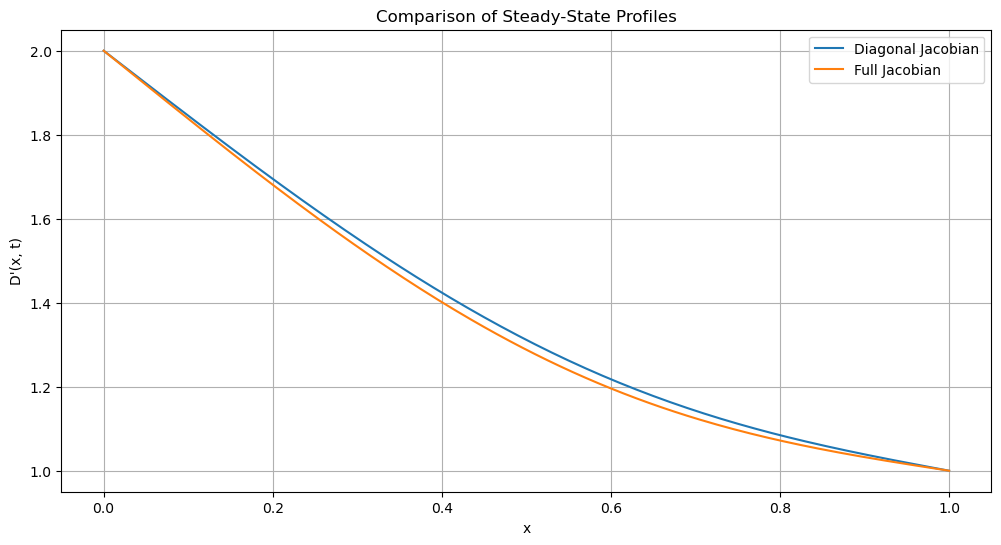

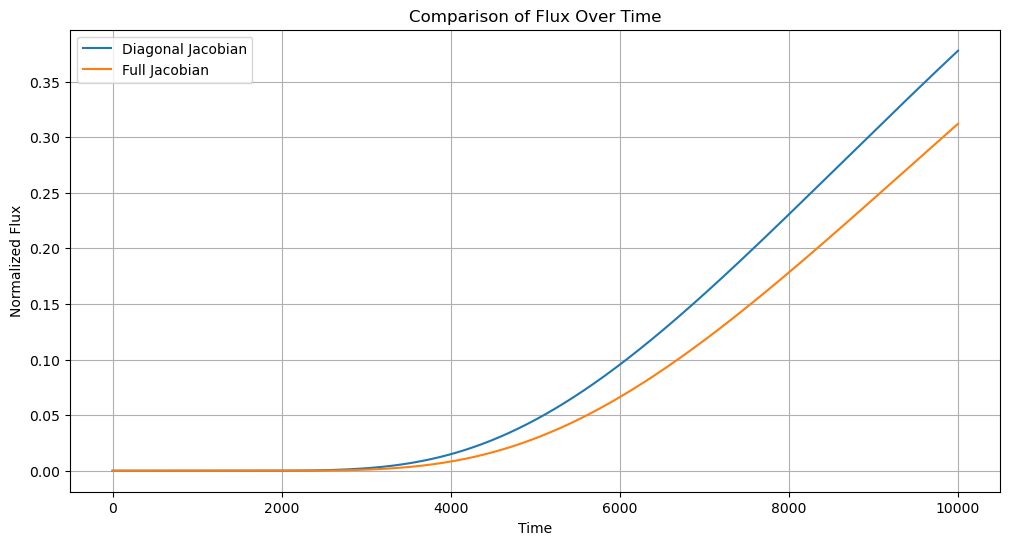

Time taken for Diagonal Jacobian: 0.7481 seconds
Time taken for Full Jacobian: 3.1417 seconds


In [7]:
# Example 1
compare_jacobian_methods(D1_prime=2.0, DT_0=1e-7, T=10e3)

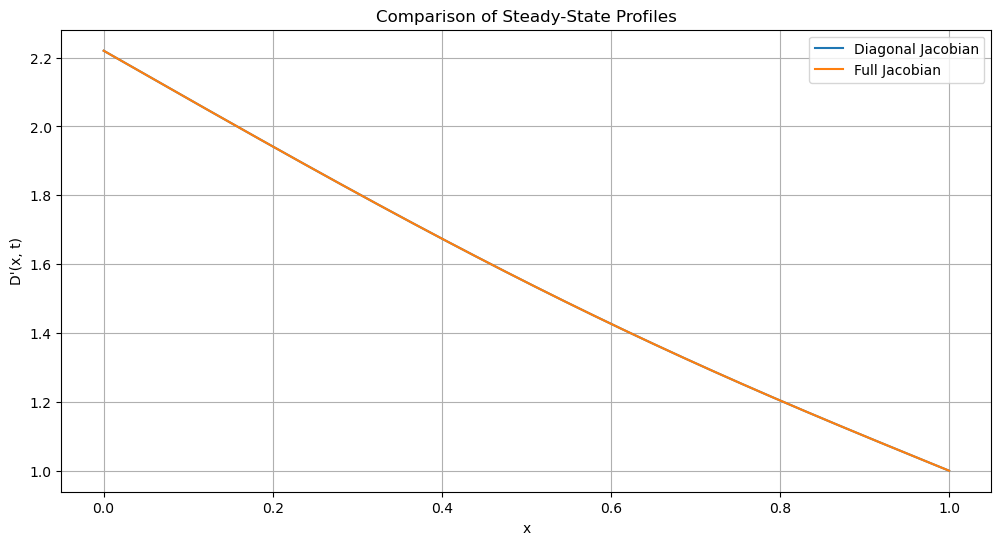

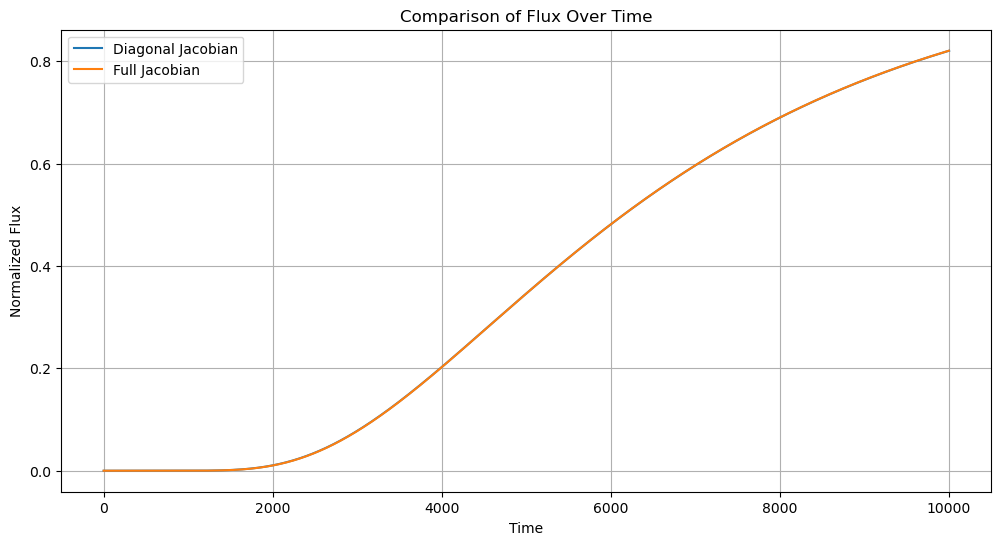

Time taken for Diagonal Jacobian: 0.7121 seconds
Time taken for Full Jacobian: 6.2317 seconds


In [ ]:
# Example 2
compare_jacobian_methods(D1_prime=2.22, DT_0=2.05e-7, T=10e3)

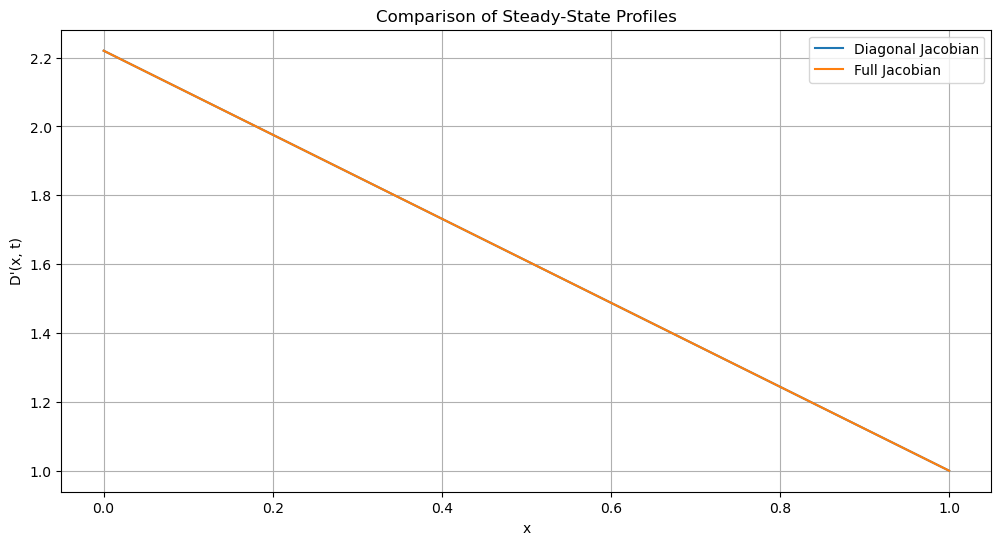

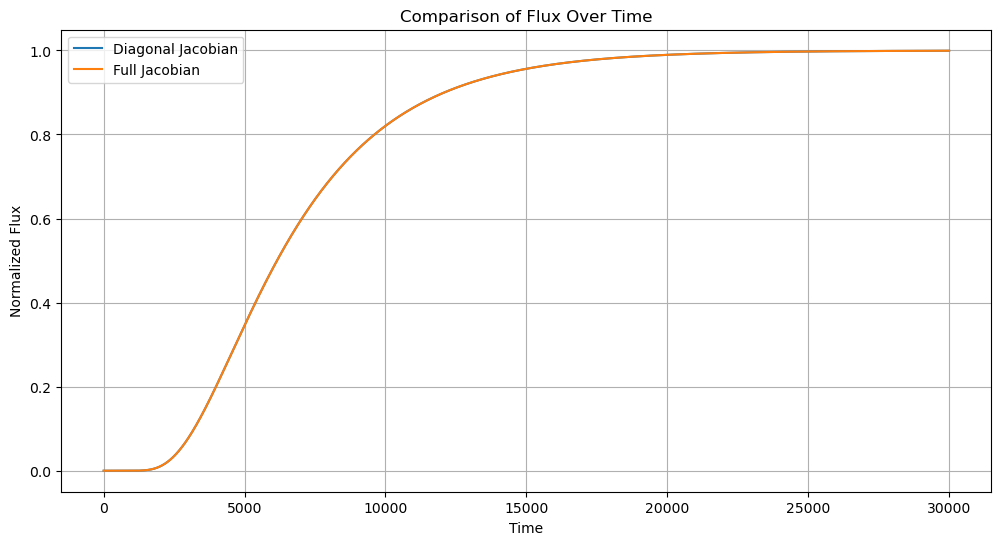

Time taken for Diagonal Jacobian: 116.1302 seconds
Time taken for Full Jacobian: 2169.5442 seconds


In [9]:
# Example 3
compare_jacobian_methods(dx=1/1000, D1_prime=2.22, DT_0=2.05e-7, T=30e3)

### Comparing Jacobian calculation methods

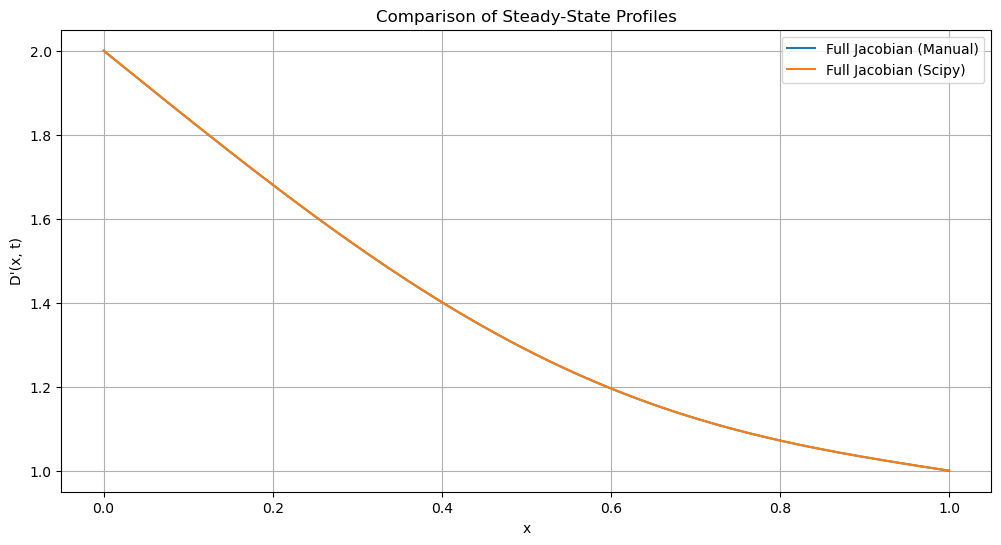

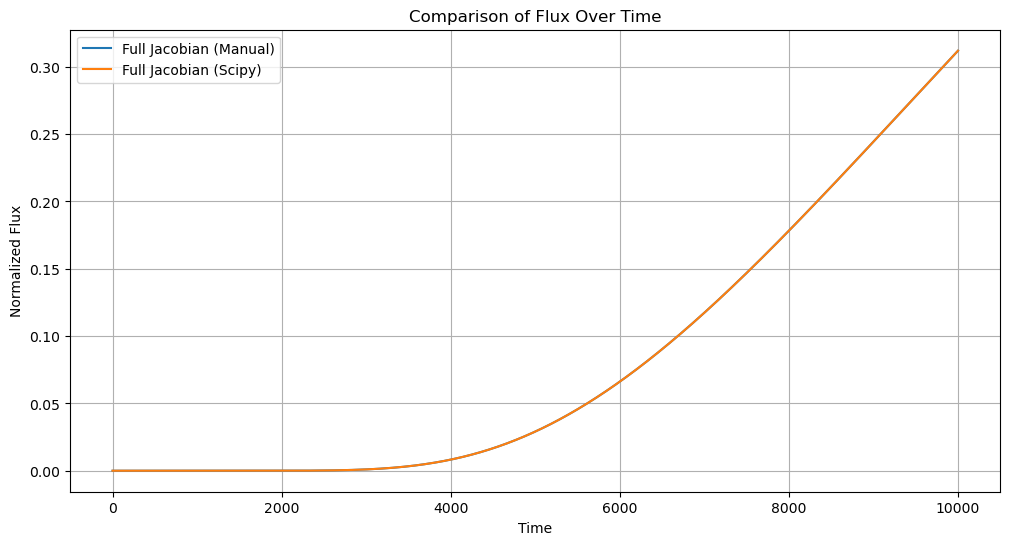

Time taken for Full Jacobian (Manual): 5.2673 seconds
Time taken for Full Jacobian (Scipy): 2.4272 seconds


In [1]:
import numpy as np
import pandas as pd
import numba as nb
import time
from scipy.sparse import diags
from scipy.linalg import solve_banded

import matplotlib.pyplot as plt


def compare_jacobian_methods(D1_prime=2.0, DT_0=1e-7, T=10e3, X=1.0, L=0.1, dx=0.005, dt=0.01,
                             rel_tol=1e-8, max_iter=100, relax=0.8):
    """
    Compares the diagonal and full Jacobian methods for solving a PDE using Newton's method.
    """

    # --- Helper Functions (JIT-compiled) ---
    @nb.njit
    def _newton_update_jit_diagonal(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol):
        """Newton iterations with diagonal Jacobian."""
        D_new = D_old.copy()
        Nx = D_old.shape[0]
        converged = 0
        dx2 = dx * dx
        for it in range(max_iter):
            R = np.empty(Nx - 2, dtype=np.float64)
            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                R[i-1] = (D_new[i] - D_old[i]) / dt - K * D_new[i] * lapl

            sumR = 0.0
            sumD = 0.0
            for i in range(Nx - 2):
                sumR += R[i] * R[i]
            for i in range(Nx - 1):
                sumD += D_new[i] * D_new[i]
            norm_R = np.sqrt(sumR)
            norm_D = np.sqrt(sumD)
            if norm_D == 0.0:
                norm_D = 1e-12

            if norm_R / norm_D < rel_tol:
                converged = 1
                break

            for i in range(1, Nx - 1):
                lapl = (D_new[i+1] - 2.0 * D_new[i] + D_new[i-1]) / dx2
                J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[i]) / dx2)
                if J_diag == 0.0:
                    J_diag = 1e-8
                D_new[i] = D_new[i] - relax * (((D_new[i] - D_old[i]) / dt) - K * D_new[i] * lapl) / J_diag

        D_new[0] = D1_prime
        D_new[Nx - 1] = D2_prime
        return D_new, converged

    @nb.njit
    def _calculate_residual(D_new, D_old, dt, dx, K):
        """Vectorized residual calculation for interior points."""
        dx2 = dx * dx
        lapl = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) / dx2
        R = (D_new[1:-1] - D_old[1:-1]) / dt - K * D_new[1:-1] * lapl
        return R

    @nb.njit
    def _calculate_jacobian_manual(D_new, dt, dx, K, Nx):
        """Calculate the Jacobian matrix elements manually."""
        dx2 = dx * dx
        J_diag = np.zeros(Nx - 2)
        J_lower = np.zeros(Nx - 3)
        J_upper = np.zeros(Nx - 3)

        # Vectorized Laplacian calculation
        lapl = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) / dx2
        
        # Diagonal elements
        J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[1:-1]) / dx2)
        
        # Off-diagonal elements
        J_lower = K * D_new[1:-2] / dx2
        J_upper = K * D_new[2:-1] / dx2
        
        return J_diag, J_lower, J_upper

    @nb.njit
    def _calculate_jacobian_scipy(D_new, dt, dx, K, Nx):
        """Calculate the Jacobian matrix elements using scipy."""
        dx2 = dx * dx
        lapl = (D_new[2:] - 2.0 * D_new[1:-1] + D_new[:-2]) / dx2
        
        # Diagonal elements
        J_diag = (1.0 / dt) - K * (lapl + (-2.0 * D_new[1:-1]) / dx2)
        
        # Off-diagonal elements
        J_lower = K * D_new[1:-2] / dx2
        J_upper = K * D_new[2:-1] / dx2
        
        return J_diag, J_lower, J_upper

    @nb.njit
    def _solve_tridiagonal(a, b, c, d):
        """Optimized Thomas algorithm for tridiagonal systems."""
        n = d.shape[0]
        x = np.zeros_like(d)
        
        # Forward sweep - modified Thomas algorithm
        c_prime = np.zeros_like(c)
        d_prime = np.zeros_like(d)
        
        c_prime[0] = c[0] / b[0]
        d_prime[0] = d[0] / b[0]
        
        for i in range(1, n):
            m = 1.0 / (b[i] - a[i-1] * c_prime[i-1])
            c_prime[i] = c[i] * m if i < n-1 else 0.0
            d_prime[i] = (d[i] - a[i-1] * d_prime[i-1]) * m
        
        # Back substitution
        x[-1] = d_prime[-1]
        for i in range(n-2, -1, -1):
            x[i] = d_prime[i] - c_prime[i] * x[i+1]
        
        return x

    @nb.njit
    def _newton_update_jit_full(D_old, dt, dx, K, max_iter, D1_prime, D2_prime, relax, rel_tol, jacobian_method="manual"):
        """Optimized Newton iterations with full Jacobian."""
        D_new = D_old.copy()
        Nx = D_old.shape[0]
        converged = 0
        dx2 = dx * dx
        
        for it in range(max_iter):
            # Compute residual
            R = _calculate_residual(D_new, D_old, dt, dx, K)
            
            # Fast norm calculations using np.dot
            norm_R = np.sqrt(np.dot(R, R))
            norm_D = np.sqrt(np.dot(D_new[1:-1], D_new[1:-1]))
            
            if norm_D == 0.0:
                norm_D = 1e-12

            if norm_R / norm_D < rel_tol:
                converged = 1
                break

            # Calculate Jacobian and solve system
            if jacobian_method == "manual":
                J_diag, J_lower, J_upper = _calculate_jacobian_manual(D_new, dt, dx, K, Nx)
            elif jacobian_method == "scipy":
                J_diag, J_lower, J_upper = _calculate_jacobian_scipy(D_new, dt, dx, K, Nx)
            else:
                raise ValueError("Invalid Jacobian method specified.")
            
            update = _solve_tridiagonal(J_lower, J_diag, J_upper, -R)
            
            # Update solution with vectorized operation
            D_new[1:-1] += relax * update
            D_new[0] = D1_prime
            D_new[-1] = D2_prime

        return D_new, converged

    # --- PDE Solving Functions ---
    def _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                      D2_prime=1.0, rel_tol=1e-8, max_iter=100, relax=0.8,
                      dt_init=0.0005, dt_target=10, dt_min=1e-6, dt_ramp_factor=1.1,
                      jacobian_method="manual"):
        """Adaptive implicit PDE solver using Newton's method with full Jacobian."""
        Nx = int(X / dx) + 1
        x = np.linspace(0, X, Nx)
        K = DT_0 / (L * L)
        D0 = np.ones(Nx, dtype=np.float64)
        D0[0] = D1_prime
        D0[-1] = D2_prime

        t_history = [0.0]
        D_history = [D0.copy()]
        current_t = 0.0
        dt = dt_init

        while current_t < T:
            accepted = False
            trial_dt = dt
            current_relax = relax
            while not accepted:
                D_new, converged = _newton_update_jit_full(D_history[-1], trial_dt, dx, K,
                                                    max_iter, D1_prime, D2_prime, current_relax, rel_tol, jacobian_method)
                if converged == 1:
                    accepted = True
                else:
                    trial_dt *= 0.5
                    if trial_dt < dt_min:
                        trial_dt = dt_min
                        current_relax = current_relax * 0.5
            if trial_dt < dt_target:
                new_dt = min(trial_dt * dt_ramp_factor, dt_target)
                dt = new_dt
            else:
                dt = trial_dt
            current_t += dt
            t_history.append(current_t)
            D_history.append(D_new.copy())

        D_arr = np.array(D_history)
        t_arr = np.array(t_history)
        F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)

        Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_arr)
        flux_df = pd.DataFrame({
            "time": t_arr,
            "normalised_flux": F_norm,
            "tau": DT_0 * t_arr / (L * L)
        })

        return Dprime_df, flux_df

    # --- Solve and Compare ---
    # Solve PDE using full Jacobian with manual calculation
    start_time_manual = time.time()
    Dprime_df_manual, flux_df_manual = _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                                              rel_tol=rel_tol, max_iter=max_iter, relax=relax, jacobian_method="manual")
    end_time_manual = time.time()
    time_manual = end_time_manual - start_time_manual

    # Solve PDE using full Jacobian with scipy calculation
    start_time_scipy = time.time()
    Dprime_df_scipy, flux_df_scipy = _solve_pde_full(D1_prime, DT_0, T, X, L, dx,
                                              rel_tol=rel_tol, max_iter=max_iter, relax=relax, jacobian_method="scipy")
    end_time_scipy = time.time()
    time_scipy = end_time_scipy - start_time_scipy

    # --- Plotting ---
    x_values = [float(col[2:]) for col in Dprime_df_manual.columns]

    plt.figure(figsize=(12, 6))
    plt.plot(x_values, Dprime_df_manual.iloc[-1, :], label="Full Jacobian (Manual)")
    plt.plot(x_values, Dprime_df_scipy.iloc[-1, :], label="Full Jacobian (Scipy)")
    plt.xlabel("x")
    plt.ylabel("D'(x, t)")
    plt.title("Comparison of Steady-State Profiles")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(flux_df_manual["time"], flux_df_manual["normalised_flux"], label="Full Jacobian (Manual)")
    plt.plot(flux_df_scipy["time"], flux_df_scipy["normalised_flux"], label="Full Jacobian (Scipy)")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.title("Comparison of Flux Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Time taken for Full Jacobian (Manual): {time_manual:.4f} seconds")
    print(f"Time taken for Full Jacobian (Scipy): {time_scipy:.4f} seconds")

# --- Example Usage ---
compare_jacobian_methods()

# Python solver

## solve_ivp

### Iteration 1

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
import time

def solve_permeation_with_solve_ivp(D1_prime=2.0, DT_0=1e-7, T=10e3, X=1.0, L=0.1, dx=0.005,
                                   D2_prime=1.0, rtol=1e-8, atol=1e-10):
    """
    Solves the permeation PDE using scipy's solve_ivp
    
    Parameters:
    -----------
    D1_prime : float
        Diffusivity at the high-concentration boundary
    DT_0 : float
        Characteristic diffusivity constant
    T : float
        Total simulation time
    X : float
        Normalized spatial domain length
    L : float
        Actual membrane thickness (m)
    dx : float
        Spatial step size
    D2_prime : float
        Diffusivity at the low-concentration boundary
    rtol : float
        Relative tolerance for solver
    atol : float
        Absolute tolerance for solver
        
    Returns:
    --------
    Dprime_df : DataFrame
        Diffusivity profiles at each time point
    flux_df : DataFrame
        Normalized flux over time
    """
    # Discretize space
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx)
    K = DT_0 / (L * L)
    
    # Define the ODE system derived from Method of Lines
    def diffusion_ode(t, D):
        """Convert PDE to system of ODEs using Method of Lines"""
        dDdt = np.zeros_like(D)
        dx2 = dx * dx
        
        # Apply interior points dynamics
        for i in range(1, len(D)-1):
            lapl = (D[i+1] - 2.0*D[i] + D[i-1]) / dx2
            dDdt[i] = K * D[i] * lapl
        
        # Boundary conditions
        dDdt[0] = 0  # Fixed D1_prime (Dirichlet)
        dDdt[-1] = 0  # Fixed D2_prime (Dirichlet)
        
        return dDdt
    
    # Initial condition
    D0 = np.ones(Nx)
    D0[0] = D1_prime
    D0[-1] = D2_prime
    
    # Track solution timing
    start_time = time.time()
    
    # Solve using solve_ivp with BDF method (good for stiff problems)
    print("Starting solve_ivp integration...")
    solution = solve_ivp(
        diffusion_ode, 
        t_span=[0, T],
        y0=D0,
        method='BDF',  # Backward Differentiation Formula (for stiff problems)
        rtol=rtol,
        atol=atol,
        first_step=1e-4,  # Suggested initial step
        max_step=100,   # Maximum allowed step
        dense_output=True  # Allow interpolation for output
    )
    
    end_time = time.time()
    solve_time = end_time - start_time
    print(f"Integration complete. Time taken: {solve_time:.4f} seconds")
    
    # Extract solution information
    t_eval = np.linspace(0, T, 100)  # Sample points for output
    D_history = []
    
    for t in t_eval:
        D_t = solution.sol(t)
        D_history.append(D_t)
    
    D_arr = np.array(D_history)
    
    # Calculate normalized flux
    F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create DataFrames for output
    Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_eval)
    flux_df = pd.DataFrame({
        "time": t_eval,
        "normalised_flux": F_norm,
        "tau": DT_0 * t_eval / (L * L)
    })
    
    # Basic plotting
    plt.figure(figsize=(12, 10))
    
    # Plot diffusivity profiles
    plt.subplot(2, 1, 1)
    plt.plot(x, D_arr[-1, :], 'b-', linewidth=2, label='Final state')
    plt.plot(x, D_arr[0, :], 'r--', label='Initial state')
    for i in range(1, 5):
        idx = i * len(t_eval) // 10
        if idx < len(t_eval):
            plt.plot(x, D_arr[idx, :], '--', label=f't={t_eval[idx]:.1f}')
    plt.xlabel('x')
    plt.ylabel("D'(x,t)")
    plt.title(f"Diffusivity Profile Evolution (D1'={D1_prime})")
    plt.legend()
    plt.grid(True)
    
    # Plot normalized flux
    plt.subplot(2, 1, 2)
    plt.plot(t_eval, F_norm, 'g-', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.title('Flux Evolution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Solver statistics
    print(f"Number of function evaluations: {solution.nfev}")
    print(f"Number of Jacobian evaluations: {solution.njev}")
    # The 'nst' attribute isn't available directly in solve_ivp's output
    # Instead, we can access the solver status through solution.status
    print(f"Solver status: {solution.status}")
    print(f"Number of successful steps: {solution.nfev // (solution.njev + 1)}")  # Approximate
    print(f"Solve time: {solve_time:.4f} seconds")
    
    return Dprime_df, flux_df, solution


Starting solve_ivp integration...
Integration complete. Time taken: 5.8313 seconds


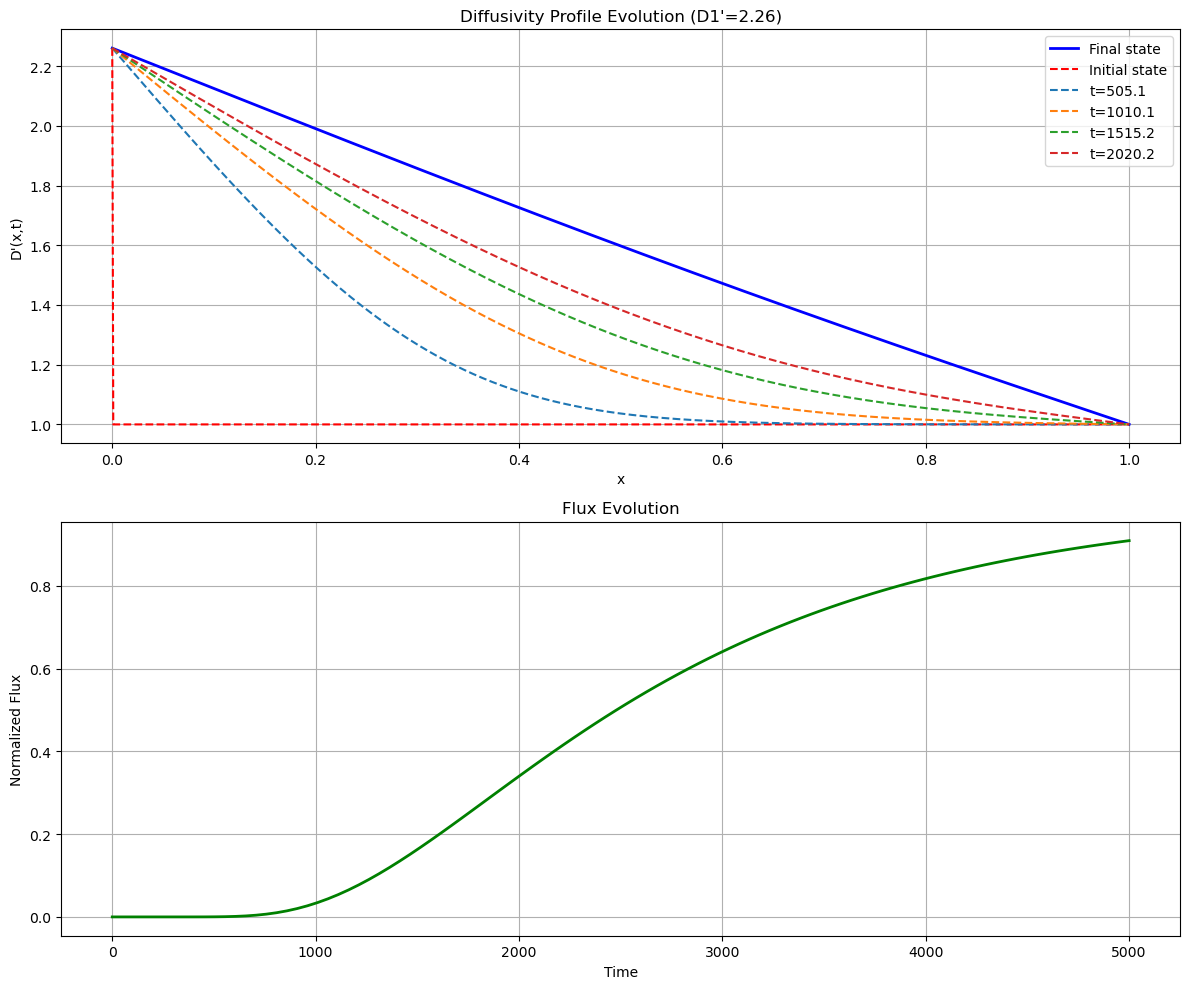

Number of function evaluations: 1306
Number of Jacobian evaluations: 7
Solver status: 0
Number of successful steps: 163
Solve time: 5.8313 seconds


In [17]:
Dprime_df, flux_df, solution = solve_permeation_with_solve_ivp(D1_prime=2.26, DT_0=4.60e-7, T=5e3, X=1.0, L=0.1, dx=0.001,)

Comparing with custom methods.

In [ ]:
def compare_with_custom_methods(D1_prime=2.0, DT_0=1e-7, T=10e3, X=1.0, L=0.1, dx=0.005):
    """
    Compare solve_ivp solution with diagonal and full Jacobian methods
    """
    # Import your existing functions here (or define them)
    # from your_module import _solve_pde_diagonal, _solve_pde_full
    
    # Solve with scipy's solve_ivp
    Dprime_df_scipy, flux_df_scipy, solution = solve_permeation_with_solve_ivp(
        D1_prime, DT_0, T, X, L, dx
    )
    
    # Compare with your custom methods here
    # Dprime_df_diag, flux_df_diag = _solve_pde_diagonal(...)
    # Dprime_df_full, flux_df_full = _solve_pde_full(...)
    
    # Plot comparison
    # ...

# Example usage
solve_permeation_with_solve_ivp(D1_prime=5.0)